<a href="https://colab.research.google.com/github/jmisf14/SteamWise/blob/main/Final_Project___Steam_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>[Final Project - Steam Video Game Recommender](#scrollTo=WehzD2KuOt96)

>>[0) Set-Up Env](#scrollTo=dTeC16S8rfn0)

>>>[0.1) Tools for Data Collection](#scrollTo=P_cm8F1frx9e)

>>>[0.2) Connect to Kaggle and Import RS Libraries](#scrollTo=ZRZ0wytlr1Wd)

>>[1) Get Data](#scrollTo=zNj8Ym3FZZ-g)

>>>[1.1) Get User Data](#scrollTo=hU5cnmM3bDBB)

>>>[1.2) Get Steam Catalog Data](#scrollTo=XJLuqnJvbMex)

>>>[1.3) Get Game Details](#scrollTo=_-b1SREBdUDA)

>>>[1.4) Expanding Game Dataset](#scrollTo=LMOxSLOreiwz)

>>>[1.5) Collect User Reviews For Each Game](#scrollTo=RXI8ggtk729s)

>>>[1.6) Huge Dataset](#scrollTo=v91Y8XgNeCZ8)

>>[2) Explore Dataset](#scrollTo=srvvNlJqqvys)

>>>[2.1) Feedback Data (explicit)](#scrollTo=GWh5bdkVwtU8)

>>>[2.2) Items metadata (structured)](#scrollTo=rhshNvsLw3c7)

>>[3) Build Recommender Systems](#scrollTo=fb1-pQCzqzw6)

>>>[3.1) Random RS](#scrollTo=nHQFk4Oyq4pU)

>>>[3.2) Popular RS](#scrollTo=eKliInarq8W9)

>>>[3.3) Content Base RS](#scrollTo=_4Iru9W5q_qv)

>>>>[3.3.1) With Normalization](#scrollTo=YccMGabJC-cT)

>>>>[3.3.2) Vectorization](#scrollTo=pMip4VqCdUaD)

>>>[3.4) Collaborative Filtering](#scrollTo=I1wAhP8IrDxV)

>>>>[3.4.1) Setup and Data Preparation](#scrollTo=0b0HVSk9tun4)

>>>>[3.4.2) Creating the User-Item Matrix](#scrollTo=qQ60QzpotyH3)

>>>>[3.4.3) Computing Item Similarity](#scrollTo=qDd-SS6rt1vT)

>>>>[3.4.4) Prediction Function Using Top-K Similar Items](#scrollTo=4xMkeFvet4q_)

>>>>[3.4.5) Generating Predictions for Test Set](#scrollTo=yJD8qjUeuAg4)

>>>>[3.4.6) Evaluating the Predictions](#scrollTo=pvqXDrzUuDki)

>>>>[3.4.7) Visualizing True vs. Predicted Ratings](#scrollTo=z0z61lCIuHK8)

>>>>[3.4.8) Complete Item-Based Collaborative Filtering Pipeline](#scrollTo=7MOAdTZouJ4k)

>>>>[3.4.9) Making Recommendations for Users](#scrollTo=NGoH_NAtuTMN)

>>[4) Split train-test](#scrollTo=Zdx7rr5W0T9P)

>>[5) Train and Test Recommender Systems](#scrollTo=ynZ03jKw0bZm)

>>[6) Metrics and Result](#scrollTo=VXIBDB7BrJ0Y)

>>>[6.1) Analize Results](#scrollTo=uU2HXeSK2cKp)

>>>[6.2) Accuracy](#scrollTo=MVSAQlPt3Eup)

>>>[6.3) Coverage](#scrollTo=dByBLIUu3FmK)

>>>[6.4) Personalization](#scrollTo=tWZ0vrSlC8g0)

>>>[6.5) Diversity](#scrollTo=MNTPKc743NEK)

>>>[6.6) Ranking (NDCG score)](#scrollTo=7cXR661Y9eqb)



# **Final Project - Steam Video Game Recommender**

*Videogames Recommender System for steam gamers.*

**By: Gregorio, Anthony, Tomas, and Jose**

## <font color="gray">0) Set-Up Env

### 0.1) Tools for Data Collection

In [ ]:
import requests
import pandas as pd
import time
from tqdm import tqdm
from google.colab import files, userdata

### 0.2) Connect to Kaggle and Import RS Libraries

In [ ]:
# Let's re-install a lower version of matplotlib as it has incompatibilities with recmetrics library
!pip install -q matplotlib==3.7.3

# Important note: Once installed, restart runtime (no disconnect) so this specific version is used,
# as Colab imports matplotlib already with the latest version by default

LOAD DATASET

In [ ]:
def setup_kaggle():
  from google.colab import files
  uploaded = files.upload()
  !chmod 600 kaggle.json
  %mkdir -p /root/.kaggle/
  %mv kaggle.json /root/.kaggle/

setup_kaggle()

# Important note: If kaggle complains, change the path /root/.kaggle/ to the one
# specified in the error trace (e.g. /root/.config/kaggle/)

Saving kaggle.json to kaggle.json


In [ ]:
!pip install -q kaggle recmetrics

import kaggle
kaggle.api.authenticate()

import recmetrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# Just aesthetic to not show irrelevant warnings
import warnings; warnings.filterwarnings("ignore")

In [ ]:
!pip install -q surprise

import sklearn.metrics as metrics
from tqdm import tqdm
from IPython.display import clear_output
import seaborn as sns

from surprise import Reader, Dataset, SVD, SVDpp, NMF, accuracy, Prediction, AlgoBase
from surprise.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import ndcg_score

import random
my_seed = 1234
random.seed(my_seed)
np.random.seed(my_seed)

## <font color="green">1) Get Data

<font color="RED">*NO NEED TO RUN THIS SECTION!!**

**THIS SECTION FETCHES, SHAPES, AND SAVES THE DATA FOR OUR DATASET, TAKING MANY HOURS!!**

**The data is available in Kaggle!**

### 1.1) Get User Data

In [ ]:
STEAM_API_KEY = '820789984D613D570C2FD4E0D711AFB1'
#STEAM_API_KEY = userdata.get('STEAM_API_KEY')
STEAM_ID = '76561198153704486'

url = f'https://api.steampowered.com/IPlayerService/GetOwnedGames/v1/?key={STEAM_API_KEY}&steamid={STEAM_ID}&include_appinfo=true&include_played_free_games=true'

response = requests.get(url)
data = response.json()

In [ ]:
games = data['response'].get('games', [])
df = pd.DataFrame(games)

# Clean and view
df = df[['appid', 'name', 'playtime_forever']]
df['playtime_hours'] = df['playtime_forever'] / 60
df = df.drop(columns='playtime_forever')

print(f"Total count of games: {df.shape[0]}\n")
display(df.head())

Total count of games: 278



,appid,name,playtime_hours
0,4000,Garry's Mod,22.950000
1,17390,Spore,13.650000
2,550,Left 4 Dead 2,4.466667
3,400,Portal,2.566667
4,620,Portal 2,26.433333


In [ ]:
print("Sorted by ascending App ID\n")
display(df.sort_values('appid').head())

Sorted by ascending App ID



,appid,name,playtime_hours
271,220,Half-Life 2,0.000000
272,320,Half-Life 2: Deathmatch,0.000000
273,360,Half-Life Deathmatch: Source,0.000000
3,400,Portal,2.566667
275,440,Team Fortress 2,481.183333


In [ ]:
print("Sorted by descending playtime hours")
display(df.sort_values('playtime_hours', ascending=False).head())

Sorted by descending playtime hours


,appid,name,playtime_hours
275,440,Team Fortress 2,481.183333
28,281990,Stellaris,390.816667
122,548430,Deep Rock Galactic,352.750000
257,1086940,Baldur's Gate 3,338.516667
180,992070,Idle Wizard,307.783333


### 1.2) Get Steam Catalog Data

In [ ]:
url = 'https://api.steampowered.com/ISteamApps/GetAppList/v2/'

response = requests.get(url)
apps = response.json()['applist']['apps']

df_apps = pd.DataFrame(apps)
print(f"shape: {df_apps.shape}\n")
display(df_apps.sort_values('name', ascending=True).head())

shape: (239955, 2)



,appid,name
0,1941401,
21,1700632,
22,1567401,
23,2016512,
24,2092072,


In [ ]:
df_apps = df_apps.drop_duplicates(subset=['appid'])  # Drop duplicate games

print(f"Count of games after removing duplicates: {df_apps.shape[0]}\n")

display(df_apps.sort_values('name', ascending=True).head())

Count of games after removing duplicates: 193360



,appid,name
0,1941401,
21,1700632,
22,1567401,
23,2016512,
24,2092072,


### 1.3) Get Game Details

In [ ]:
def get_app_details(appid):
    url = f'https://store.steampowered.com/api/appdetails?appids={appid}'
    resp = requests.get(url)
    data = resp.json()
    if data[str(appid)]['success']:
        return data[str(appid)]['data']
    return None

In [ ]:
details = get_app_details(440)  # Team Fortress 2
display(details['name'], details.get('genres'), details.get('categories'))

'Team Fortress 2'

[{'id': '1', 'description': 'Action'},
 {'id': '37', 'description': 'Free To Play'}]

[{'id': 1, 'description': 'Multi-player'},
 {'id': 27, 'description': 'Cross-Platform Multiplayer'},
 {'id': 22, 'description': 'Steam Achievements'},
 {'id': 29, 'description': 'Steam Trading Cards'},
 {'id': 13, 'description': 'Captions available'},
 {'id': 30, 'description': 'Steam Workshop'},
 {'id': 35, 'description': 'In-App Purchases'},
 {'id': 18, 'description': 'Partial Controller Support'},
 {'id': 8, 'description': 'Valve Anti-Cheat enabled'},
 {'id': 15, 'description': 'Stats'},
 {'id': 17, 'description': 'Includes level editor'},
 {'id': 14, 'description': 'Commentary available'},
 {'id': 41, 'description': 'Remote Play on Phone'},
 {'id': 42, 'description': 'Remote Play on Tablet'}]

### 1.4) Expanding Game Dataset

In [ ]:
def get_app_details(appid):
    url = f'https://store.steampowered.com/api/appdetails?appids={appid}&cc=ES'
    try:
        resp = requests.get(url, timeout=10)
        data = resp.json()
        if data.get(str(appid), {}).get('success'):
            return data[str(appid)]['data']
    except:
        pass
    return None

In [ ]:
def get_current_players(appid):
    url = f'https://api.steampowered.com/ISteamUserStats/GetNumberOfCurrentPlayers/v1/?appid={appid}'
    try:
        resp = requests.get(url, timeout=10)
        return resp.json().get('response', {}).get('player_count', None)
    except:
        return None

In [ ]:
def get_review_score(appid):
    url = f"https://steamspy.com/api.php?request=appdetails&appid={appid}"
    try:
        r = requests.get(url, timeout=10)
        data = r.json()
        pos = data.get('positive', 0)
        neg = data.get('negative', 0)

        if (pos + neg) == 0:
            return None  # Avoid divide-by-zero

        score = pos / (pos + neg)
        return round(score, 4) * 100
    except:
        return None

In [ ]:
# We tried adding an adult filter, but due to the way Seam handles tags, it filtered out more content than we wanted.

#def is_adult_game(details):
#    descriptors = details.get('content_descriptors', {})
#    ids = descriptors.get('ids', [])
#    notes = descriptors.get('notes', '')
#
#    if 2 in ids:
#        return True
#    #if notes and any(term in notes.lower() for term in ['sexual', 'nudity', 'adult', 'explicit']):
#    if notes and any(term in notes.lower() for term in ['sexual', 'adult']):
#        return True
#    return False

In [ ]:
def enrich_apps(df_apps, max_entries=None, sleep_sec=0.25):
    enriched_data = []
    total_available = len(df_apps) if max_entries is None else min(max_entries, len(df_apps))

    for i, row in tqdm(df_apps.iterrows(), total=total_available):
        if max_entries and i >= max_entries:
            break

        appid = row['appid']
        name = row['name']
        details = get_app_details(appid)

        if not details or details.get('type') != 'game':
            continue

        price_info = details.get('price_overview', {})
        initial_price = price_info.get('initial', 0) / 100
        final_price = price_info.get('final', 0) / 100
        discount_percent = price_info.get('discount_percent', 0)

        enriched_data.append({
            'game_id': appid,
            'name': name,
            'genres': ', '.join([g['description'] for g in details.get('genres', [])]) if 'genres' in details else None,
            'current_price': final_price,
            'original_price': initial_price,
            'discount_percent': discount_percent,
            'average_rating_score': get_review_score(appid),
            'release_date': details.get('release_date', {}).get('date')
        })

        time.sleep(sleep_sec)

    return pd.DataFrame(enriched_data)

In [ ]:
#max_entries = 200

enriched_df = enrich_apps(df_apps, max_entries=200)
enriched_df.to_csv('steam_games_data.csv', index=False)

100%|██████████| 200/200 [00:13<00:00, 14.81it/s]


In [ ]:
display(enriched_df.sort_values('discount_percent', ascending=False).head())

,game_id,name,genres,current_price,original_price,discount_percent,average_rating_score,release_date
0,2167380,Ricochet Rodeo,"Action, Indie",4.99,4.99,0,94.12,"12 Nov, 2024"
1,2167390,Grotesque Realm,"Action, Adventure, Indie, Early Access",19.50,19.50,0,88.89,"3 Jun, 2023"
2,2167400,The Mixer,"Action, Indie",0.00,0.00,0,NaN,Coming soon
3,2167430,軍靴をはいた猫,Adventure,33.99,33.99,0,79.41,"24 Feb, 2023"


In [ ]:
enriched_df.shape

(4, 8)

### 1.5) Collect User Reviews For Each Game

---



In [ ]:
def get_reviews_for_game(appid, max_reviews=100, language='english'):
    url = f'https://store.steampowered.com/appreviews/{appid}?json=1&filter=recent&language={language}&num_per_page=100'
    reviews = []

    cursor = '*'
    count = 0

    while count < max_reviews:
        paginated_url = f"{url}&cursor={cursor}"
        try:
            r = requests.get(paginated_url)
            if r.status_code != 200:
                break

            data = r.json()
            batch = data.get('reviews', [])
            if not batch:
                break

            for review in batch:
                reviews.append({
                    'game_id': appid,
                    'user_id': review['author']['steamid'],
                    'rating': int(review['voted_up']),
                    'review': review['review']
                })
                count += 1
                if count >= max_reviews:
                    break

            cursor = data.get('cursor')
            if not cursor:
                break

            time.sleep(0.5)  # Be polite to Steam servers

        except Exception as e:
            print(f"Error fetching reviews for {appid}: {e}")
            break

    return reviews

***Testing with Dota 2***

In [ ]:
#reviews = get_reviews_for_game(570, max_reviews=1000000000)  # Testing with Dota 2
#df_reviews_dota2 = pd.DataFrame(reviews)
#print(df_reviews_dota2.shape)
#df_reviews_dota2.head()

In [ ]:
#df_reviews_dota2.to_csv('steam_reviews_dota2.csv', index=False)

In [ ]:
#reviews = get_reviews_for_game(570, max_reviews=1000000000, language='all')  # Testing with Dota 2, fetching reviews with all languages
#df_reviews_dota2 = pd.DataFrame(reviews)
#print(df_reviews_dota2.shape)
#df_reviews_dota2.head()

In [ ]:
def collect_reviews_from_all_games(enriched_df, max_reviews_per_game=100):
    all_reviews = []

    for appid in tqdm(enriched_df['game_id'].tolist()):
        reviews = get_reviews_for_game(appid, max_reviews=max_reviews_per_game)
        all_reviews.extend(reviews)

    return pd.DataFrame(all_reviews)

In [ ]:
df_reviews = collect_reviews_from_all_games(enriched_df, max_reviews_per_game=100)

df_reviews.to_csv('steam_reviews.csv', index=False)

100%|██████████| 4/4 [00:00<00:00, 21.31it/s]


### 1.6) Huge Dataset

In [ ]:
df_huge = enrich_apps(df_apps, max_entries=None)
df_huge.to_csv('steam_games_data.csv', index=False)

  0%|          | 442/193360 [00:25<5:58:39,  8.96it/s]

In [ ]:
df_reviews_huge = collect_reviews_from_all_games(df_huge, max_reviews_per_game=50)
df_reviews_huge.to_csv('steam_reviews.csv', index=False)

In [ ]:
# Count unique game_ids.
unique_game_ids = df_reviews_huge['game_id'].nunique()

print(f"Number of unique game IDs in df_reviews_huge: {unique_game_ids}")


## <font color="green">2) Explore Dataset

In [ ]:
dataset_path = 'tmesalles/steam-recommender'
kaggle.api.dataset_download_files(dataset_path, path=dataset_path, unzip=True)
! ls $dataset_path

Dataset URL: https://www.kaggle.com/datasets/tmesalles/steam-recommender
steam_games_data.csv  steam_reviews.csv


We scraped 2 dataframes,

one for more structured data and metadata, that we will use for Content Based RS,

and another one for strict item, user, and rating.

### 2.1) Feedback Data (explicit)

In [ ]:
ratings_df = pd.read_csv(f'{dataset_path}/steam_reviews.csv')
ratings_df.head()

,game_id,user_id,rating,review
0,3322740,76561199245172448,0,Why this game is not tagged as survival horror...
1,3322740,76561198218674980,0,gatau ya kenapa game ini terlalu flat banyak m...
2,3322740,76561197961926886,1,I was able to beat this game after around a mi...
3,3322780,76561199094964891,1,my son is super excited to play i love it just...
4,3322780,76561198102210881,1,One of my favorite video game genres are Fishi...


---

GET IDEA OF ITEMS, USERS AND RATINGS WE HAVE

In [ ]:
def basic_stats(ratings_df, user_col, item_col):
  n_ratings = ratings_df.shape[0]
  n_users = ratings_df[user_col].nunique()
  n_items = ratings_df[item_col].nunique()
  print(f'There are {n_ratings} ratings from {n_users} users to {n_items} items')
  return n_ratings, n_users, n_items

In [ ]:
n_ratings, n_users, n_items = basic_stats(ratings_df, 'user_id', 'game_id')

There are 8473 ratings from 8010 users to 481 items


The data has 8.473 ratings,

from 8010 users,

to 481 games.

<br>

This means that we have a lot of rtings for few items, but few ratings comming from the same user.

---

**LONG TAIL PHENOMENOM**

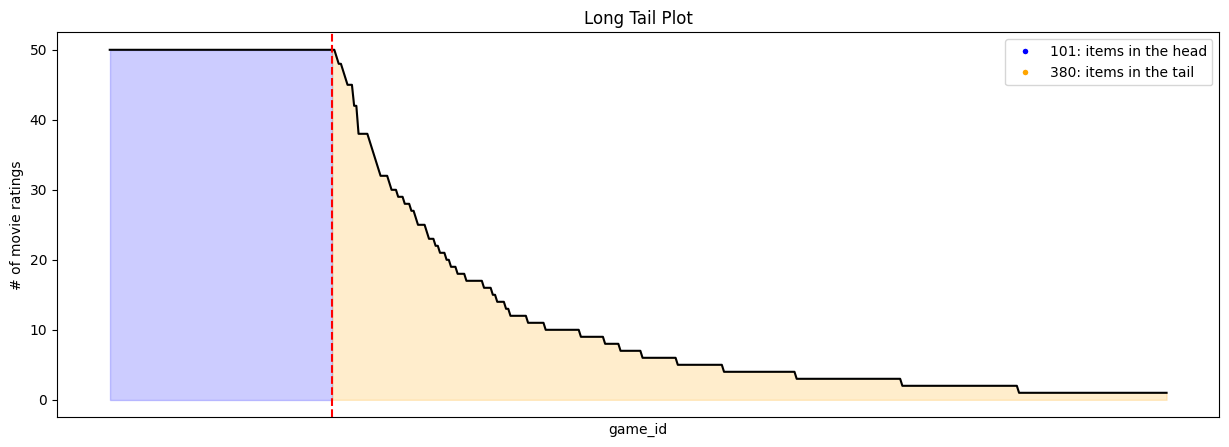

In [ ]:
plt.figure(figsize=(15, 5))
recmetrics.long_tail_plot(df=ratings_df,
                          item_id_column="game_id",
                          interaction_type="movie ratings",
                          percentage=0.6, # THERSHOLD IS JUST FOR AESTETIC
                          x_labels=False) # LONG TAIL PHENOMENO OCCURS

In [ ]:
''' See how much 10% of games are responsable for overall rating. '''
''' I expect high values, just because this is a confirmation of the long tail phenomenon. '''

ratings_df.groupby('game_id').size().sort_values(ascending=False).cumsum().iloc[int(n_items*0.10)] / ratings_df.shape[0] * 100

28.915378260356427

In [ ]:
''' See how much 10% of users are responsable for overall rating. '''
''' I expect high values, just because this is a confirmation of the long tail phenomenon. '''

ratings_df.groupby('user_id').size().sort_values(ascending=False).cumsum().iloc[int(n_users*0.10)] / ratings_df.shape[0] * 100

14.929776938510564

---

SOME PLOTS

The ratings in steam are ighter 0 (for negative feedback) or 1 (for positive feedback)

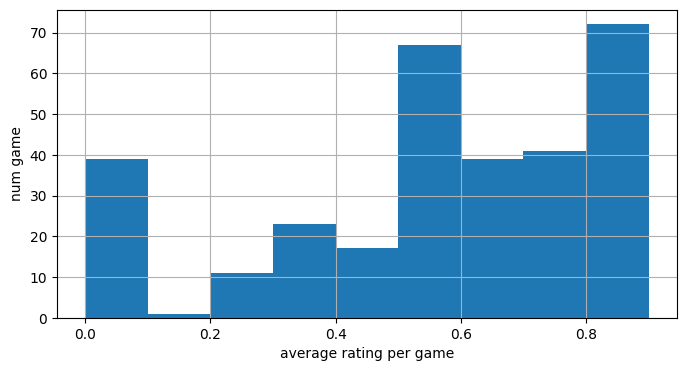

In [ ]:
''' Plot ratings per game. '''

plt.figure(figsize=(8, 4))
ratings_df.groupby('game_id')['rating'].mean().hist(bins=np.arange(0, 1, 0.1));
plt.xlabel('average rating per game');
plt.ylabel('num game');

Average rating for games is mostly positive

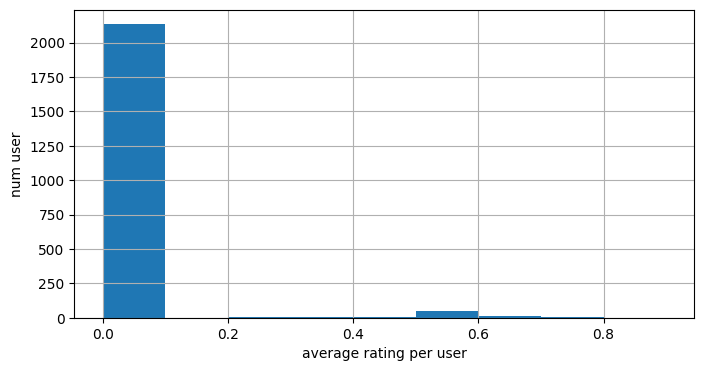

In [ ]:
''' Plot ratings per user. '''

plt.figure(figsize=(8, 4))
ratings_df.groupby('user_id')['rating'].mean().hist(bins=np.arange(0, 1, 0.1));
plt.xlabel('average rating per user');
plt.ylabel('num user');

average rating for users is very low

### 2.2) Items metadata (structured)

In [ ]:
items_df = pd.read_csv(f'{dataset_path}/steam_games_data.csv')
items_df.head()

,game_id,name,genres,current_price,original_price,discount_percent,average_rating_score,release_date
0,3322640,99% - The Remaining Subject -,"Action, Indie, Simulation",5.89,5.89,0,46.67,"21 Jan, 2025"
1,3322650,欺诈之森,"Adventure, Indie, Strategy",0.99,0.99,0,NaN,"18 Mar, 2025"
2,3322670,ヒバリでなくナイチンゲールでもなく,Adventure,0.00,0.00,0,NaN,To be announced
3,3322710,ドラゴンフィッシング,"Action, Casual, Indie, Free To Play",0.00,0.00,0,NaN,"26 Nov, 2024"
4,3322730,Nocturnal Visitors: Book One,"Adventure, Casual, Indie",0.00,0.00,0,NaN,Q4 2025


In [ ]:
items_df['genres'] = items_df['genres'].fillna('').apply(lambda x: x.split(', ') if x else []) # Because we have some NaN
items_df_exploded = items_df.explode('genres')
items_df_exploded.head()

,game_id,name,genres,current_price,original_price,discount_percent,average_rating_score,release_date
0,3322640,99% - The Remaining Subject -,Action,5.89,5.89,0,46.67,"21 Jan, 2025"
0,3322640,99% - The Remaining Subject -,Indie,5.89,5.89,0,46.67,"21 Jan, 2025"
0,3322640,99% - The Remaining Subject -,Simulation,5.89,5.89,0,46.67,"21 Jan, 2025"
1,3322650,欺诈之森,Adventure,0.99,0.99,0,NaN,"18 Mar, 2025"
1,3322650,欺诈之森,Indie,0.99,0.99,0,NaN,"18 Mar, 2025"


In [ ]:
px.histogram(items_df_exploded, x='genres', height=400, title='Steam count by genre').update_xaxes(categoryorder="total descending")

Most games are *'indie'*

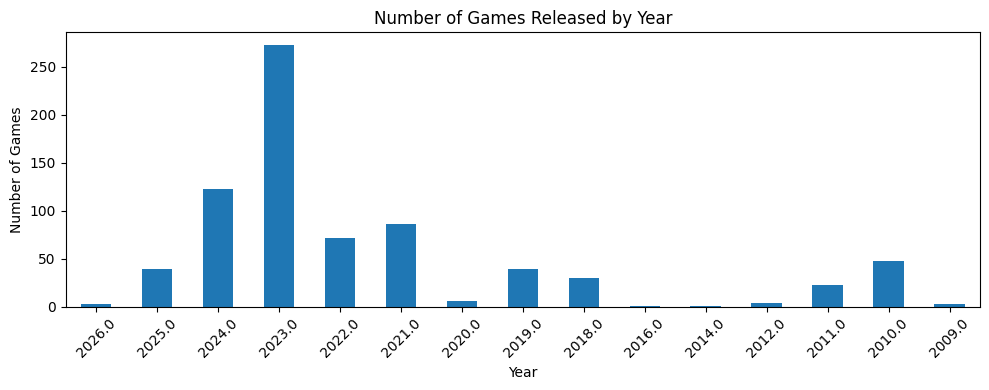

In [ ]:
# Convert release_date to datetime
items_df['release_date'] = pd.to_datetime(items_df['release_date'], errors='coerce')

# Extract year from release_date
items_df['year'] = items_df['release_date'].dt.year

# Create the plot
plt.figure(figsize=(10, 4))
release_counts = items_df.groupby('year').size().sort_index(ascending=False)

# Plot the bar chart
release_counts.plot(kind='bar')
plt.title('Number of Games Released by Year')
plt.xlabel('Year')
plt.ylabel('Number of Games')
plt.xticks(rotation=45)
plt.tight_layout()

Most games was released in 2023

In [ ]:
# Basic price statistics
print("Price Statistics:")
print(items_df['current_price'].describe())

Price Statistics:
count    943.000000
mean       4.872333
std       13.955987
min        0.000000
25%        0.000000
50%        0.990000
75%        5.275000
max      194.990000
Name: current_price, dtype: float64


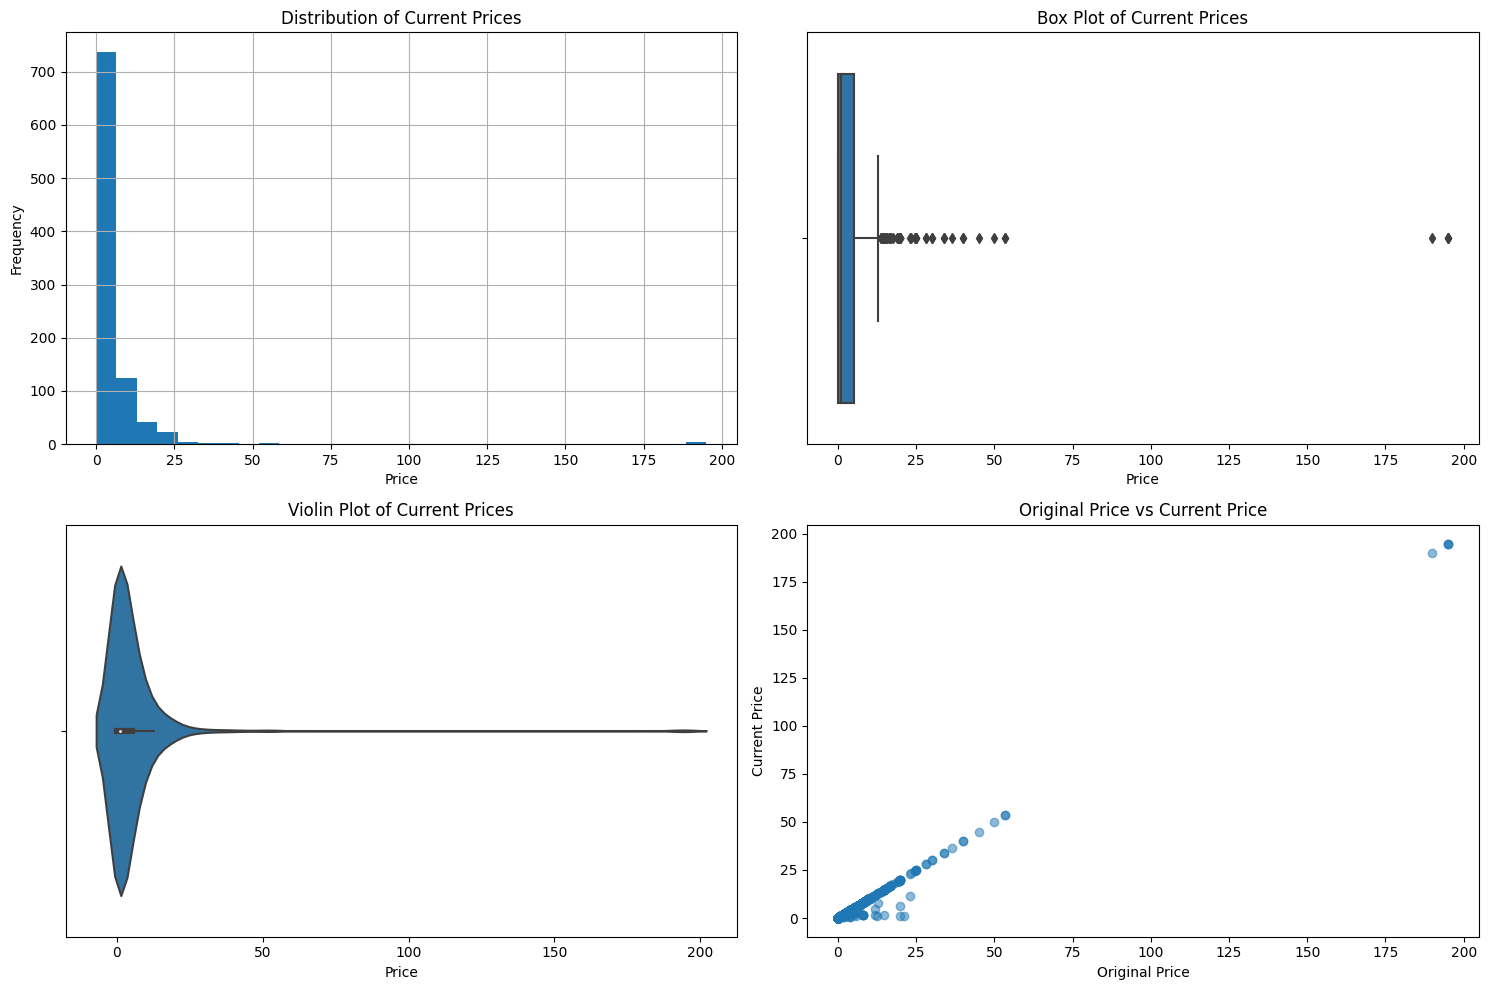

In [ ]:
# Create subplots for different price visualizations
plt.figure(figsize=(15, 10))
# 1. Histogram of Current Prices
plt.subplot(2, 2, 1)
items_df['current_price'].hist(bins=30)
plt.title('Distribution of Current Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')

# 2. Box Plot of Prices
plt.subplot(2, 2, 2)
sns.boxplot(x=items_df['current_price'])
plt.title('Box Plot of Current Prices')
plt.xlabel('Price')

# 3. Violin Plot of Prices
plt.subplot(2, 2, 3)
sns.violinplot(x=items_df['current_price'])
plt.title('Violin Plot of Current Prices')
plt.xlabel('Price')

# 4. Scatter Plot of Original vs Current Prices
plt.subplot(2, 2, 4)
plt.scatter(items_df['original_price'], items_df['current_price'], alpha=0.5)
plt.title('Original Price vs Current Price')
plt.xlabel('Original Price')
plt.ylabel('Current Price')

plt.tight_layout()

Most games are under 25€, and there are very few outliers arround higher prices

Also, we can notice that most games, have same original and current price. None of them had a decrease in price, and some had an increase (probably we can clonclude that if a game is doing good, the price might increase, otherwise the price will stay steady).

In [ ]:
items_df.shape[0]

943

943 rows

In [ ]:
items_df.dtypes

,0
game_id,int64
name,object
genres,object
current_price,float64
original_price,float64
discount_percent,int64
average_rating_score,float64
release_date,datetime64[ns]
year,float64


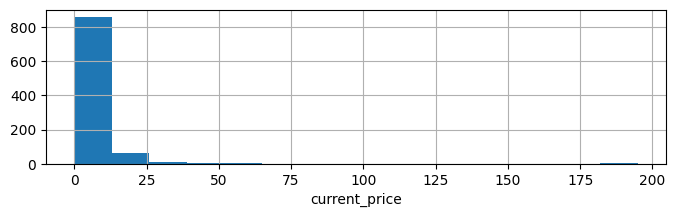

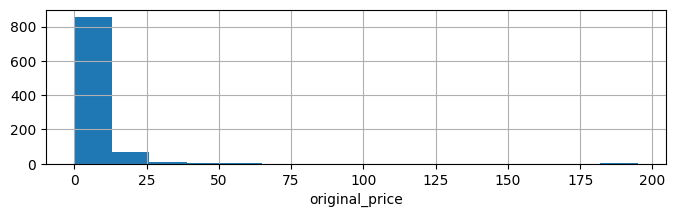

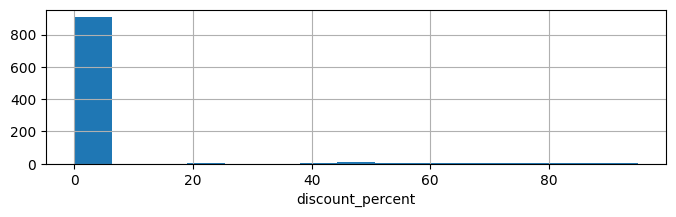

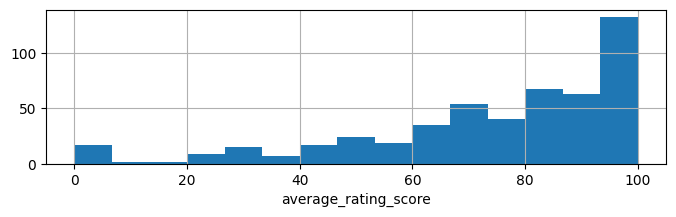

In [ ]:
num_columns = ['current_price', 'original_price', 'discount_percent', 'average_rating_score']

for col in num_columns:
  plt.subplots(figsize=(8,2))
  items_df[col].hist(bins=15)
  plt.xlabel(col)
  plt.show()

## <font color="green">3) Build Recommender Systems

### 3.1) Random RS

In [ ]:
class MyRandomAlgorithm(AlgoBase):

    def __init__(self):
        AlgoBase.__init__(self)

    def estimate(self, u, i):
        # Note u and i are not used, this RS does not personalize based on neither the user nor the item
        return np.random.normal(loc=self.train_mean, scale=self.train_std)

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)

        ratings = [r for (_, _, r) in self.trainset.all_ratings()]
        self.train_mean = np.mean(ratings)
        self.train_std = np.std(ratings)

        return self

random_RS = MyRandomAlgorithm()

### 3.2) Popular RS

In [ ]:
class MyPopularAlgorithm(AlgoBase):

    def __init__(self):
        AlgoBase.__init__(self)

    def estimate(self, u, i):
        # Note u is not used, this RS does not personalize based on the user
        if i in self.mean_rating_per_item_df.index:
          return self.mean_rating_per_item_df.loc[i]['Rating']
        else:
          return self.trainset.global_mean

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)

        ratings_df = pd.DataFrame([[i, r] for (_, i, r) in self.trainset.all_ratings()],
                                  columns=['BGGId', 'Rating'])

        self.mean_rating_per_item_df = (ratings_df
          .groupby('BGGId')
          .agg({'Rating': 'mean'})
        )

        return self

popular_RS = MyPopularAlgorithm()

### 3.3) Content Base RS

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances

In [ ]:
#items_df = pd.read_csv(f'{dataset_path}/steam_games_data.csv')
items_df = items_df.set_index('game_id')
items_df.head()

,name,genres,current_price,original_price,discount_percent,average_rating_score,release_date,year
game_id,,,,,,,,
3322640,99% - The Remaining Subject -,"[Action, Indie, Simulation]",5.89,5.89,0,46.67,2025-01-21,2025.0
3322650,欺诈之森,"[Adventure, Indie, Strategy]",0.99,0.99,0,NaN,2025-03-18,2025.0
3322670,ヒバリでなくナイチンゲールでもなく,[Adventure],0.00,0.00,0,NaN,NaT,NaN
3322710,ドラゴンフィッシング,"[Action, Casual, Indie, Free To Play]",0.00,0.00,0,NaN,2024-11-26,2024.0
3322730,Nocturnal Visitors: Book One,"[Adventure, Casual, Indie]",0.00,0.00,0,NaN,NaT,NaN


In [ ]:
pd.set_option('display.max_colwidth', 200)
top_games = items_df.sort_values('average_rating_score', ascending=False)[['name', 'average_rating_score']].head(10)
display(top_games)
pd.reset_option('display.max_colwidth')

,name,average_rating_score
game_id,,
2189150,Conspiracy TD,100.0
2189160,まなことひとみのばわい,100.0
2189230,Hell O Corn,100.0
2554950,Raioh,100.0
1582730,AbyssMemory,100.0
1583450,BURNT ASHES,100.0
1583180,Super Vili,100.0
1583070,Landing Confirmed,100.0
1583840,R-Naught,100.0


In [ ]:
pd.set_option('display.max_colwidth', 200)
ratings_df.sort_values('rating', ascending=False)[['review', 'rating']].head(10)

,review,rating
8472,"The Magic of Three is a hidden gem of a puzzle game. It's a pity that it seems to have seen zero uptake. Look past its missteps - its inexplicably uncapitalized title, uninspired store page descri...",1
8471,"A very satisfying experience. Do not miss this, if you enjoy pure puzzle games. This is absolutely not a typical ""match three"" game with a randomised set of tiles. This game has a sokoban-like ele...",1
8470,"This was actually a really enjoyable game with several really nifty designs.\nNow, I have been quite wary of puzzle platformers because too many put too much weight on the platformer part, requiri...",1
2,"I was able to beat this game after around a minute, this game is severely buggy but it's fun to speedrun so I recommend it B)\r\nhttps://www.youtube.com/watch?v=aXDCKilq8rI",1
3,my son is super excited to play i love it just need more time to play nice job necro love the music and game,1
4,"One of my favorite video game genres are Fishing RPGs, which is incredibly niche to come across. Saw the dev advertising this game on Reddit and bought this game day 1 to try out.\n\nRPG Maker, li...",1
5,Wonderful little game to pass to time.,1
6,It's fun and exciting to try to beat your best time!,1
7,kul gejm,1
8,Fun fast paced platform movement with nice animations!,1


In [ ]:
len_overview = ratings_df["review"].astype(str).apply(lambda n: len(n.split()))
len_overview.mean()

72.62303788504661

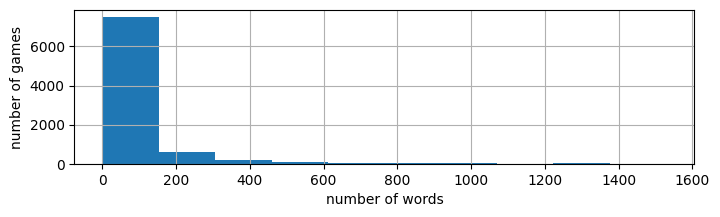

In [ ]:
plt.subplots(figsize=(8,2))
len_overview.hist(bins=10);
plt.xlabel('number of words');
plt.ylabel('number of games');

In [ ]:
items_df.describe(include='all')

,name,genres,current_price,original_price,discount_percent,average_rating_score,release_date,year
count,943,943,943.000000,943.000000,943.000000,503.000000,747,747.000000
unique,943,276,NaN,NaN,NaN,NaN,516,NaN
top,The magic of three,[],NaN,NaN,NaN,NaN,2025-01-01 00:00:00,NaN
freq,1,46,NaN,NaN,NaN,NaN,14,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,2009-10-30 00:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2026-05-12 00:00:00,NaN
mean,NaN,NaN,4.872333,5.068123,2.365854,74.529384,NaN,2021.195448
std,NaN,NaN,13.955987,13.995976,12.725536,24.859617,NaN,4.043574
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,2009.000000
25%,NaN,NaN,0.000000,0.000000,0.000000,62.430000,NaN,2021.000000


In [ ]:
items_num_df = items_df[num_columns]
items_num_df.head()

,current_price,original_price,discount_percent,average_rating_score
game_id,,,,
3322640,5.89,5.89,0,46.67
3322650,0.99,0.99,0,NaN
3322670,0.00,0.00,0,NaN
3322710,0.00,0.00,0,NaN
3322730,0.00,0.00,0,NaN


In [ ]:
euclidean_sim_num = pairwise_distances(items_num_df, items_num_df, metric='nan_euclidean', force_all_finite='allow-nan')
euclidean_sim_num_df = pd.DataFrame(euclidean_sim_num, columns=items_df.index)
euclidean_sim_num_df.index = items_df.index

In [ ]:
euclidean_sim_num_df.shape

(943, 943)

In [ ]:
euclidean_sim_num_df.head()

game_id,3322640,3322650,3322670,3322710,3322730,3322740,3322770,3322780,3322790,3322800,...,1582410,1582510,1581760,1581790,1581800,1581830,1581850,1581860,1581880,1581890
game_id,,,,,,,,,,,,,,,,,,,,,
3322640,0.000000,8.001666,9.618330,9.618330,9.618330,6.703439,9.618330,53.614447,9.618330,9.618330,...,48.810241,34.939034,15.032485,45.003555,46.883117,50.226130,6.368673,46.921803,51.213398,45.017350
3322650,8.001666,0.000000,1.616663,1.616663,1.616663,1.632993,1.616663,1.632993,1.616663,1.616663,...,17.309728,31.026870,0.000000,7.348469,30.226703,6.531973,1.632993,2.286190,11.757551,1.616663
3322670,9.618330,1.616663,0.000000,0.000000,0.000000,3.249656,0.000000,3.249656,0.000000,0.000000,...,18.926391,32.643533,1.616663,8.965132,31.843367,8.148636,3.249656,3.902854,13.374214,0.000000
3322710,9.618330,1.616663,0.000000,0.000000,0.000000,3.249656,0.000000,3.249656,0.000000,0.000000,...,18.926391,32.643533,1.616663,8.965132,31.843367,8.148636,3.249656,3.902854,13.374214,0.000000
3322730,9.618330,1.616663,0.000000,0.000000,0.000000,3.249656,0.000000,3.249656,0.000000,0.000000,...,18.926391,32.643533,1.616663,8.965132,31.843367,8.148636,3.249656,3.902854,13.374214,0.000000


In [ ]:
items_df.describe(include='all')

,name,genres,current_price,original_price,discount_percent,average_rating_score,release_date,year
count,943,943,943.000000,943.000000,943.000000,503.000000,747,747.000000
unique,943,276,NaN,NaN,NaN,NaN,516,NaN
top,The magic of three,[],NaN,NaN,NaN,NaN,2025-01-01 00:00:00,NaN
freq,1,46,NaN,NaN,NaN,NaN,14,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,2009-10-30 00:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2026-05-12 00:00:00,NaN
mean,NaN,NaN,4.872333,5.068123,2.365854,74.529384,NaN,2021.195448
std,NaN,NaN,13.955987,13.995976,12.725536,24.859617,NaN,4.043574
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,2009.000000
25%,NaN,NaN,0.000000,0.000000,0.000000,62.430000,NaN,2021.000000


In [ ]:
game_name = "Dead Space 2"
items_df['name'] = items_df['name'].fillna('')  # Replace NaN with empty string
matching_games = items_df[items_df['name'].str.contains(game_name, case=False, na=False)]

if not matching_games.empty:
    game_id_gaung = matching_games.index[0]  # Get the game_id
else:
    print(f"Game with name '{game_name}' not found. Please check the game name or data.")
    game_id_gaung = items_df.index[0]  # first game as a fallback

recommendations_df = items_num_df.copy()
recommendations_df['distance'] = euclidean_sim_num_df.loc[game_id_gaung]
recommendations = recommendations_df.sort_values('distance').head(10)

display(recommendations)

,current_price,original_price,discount_percent,average_rating_score,distance
game_id,,,,,
47780,19.99,19.99,0,94.07,0.000000
2570230,17.49,17.49,0,95.83,3.949380
1581800,19.50,19.50,0,89.42,4.701351
1583960,16.79,16.79,0,NaN,5.225578
3322260,23.40,23.40,0,NaN,5.568507
989790,16.79,16.79,0,97.88,5.915750
2570140,15.79,15.79,0,NaN,6.858571
989580,15.75,15.75,0,NaN,6.923891
2570210,19.50,19.50,0,87.10,7.004363


#### 3.3.1) With Normalization

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import pairwise_distances

In [ ]:
sc = StandardScaler()
items_num_norm_df = pd.DataFrame(sc.fit_transform(items_df[num_columns]), columns=num_columns)

In [ ]:
items_num_norm_df.describe()

,current_price,original_price,discount_percent,average_rating_score
count,9.430000e+02,9.430000e+02,9.430000e+02,5.030000e+02
mean,7.534918e-17,2.260475e-17,2.260475e-17,1.836393e-16
std,1.000531e+00,1.000531e+00,1.000531e+00,1.000996e+00
min,-3.493066e-01,-3.623050e-01,-1.860125e-01,-3.000995e+00
25%,-3.493066e-01,-3.623050e-01,-1.860125e-01,-4.871929e-01
50%,-2.783317e-01,-2.486406e-01,-1.860125e-01,2.202794e-01
75%,2.886795e-02,5.875354e-02,-1.860125e-01,8.178258e-01
max,1.362989e+01,1.357695e+01,7.283254e+00,1.025598e+00


In [ ]:
euclidean_sim_num_norm = pairwise_distances(items_num_norm_df, items_num_norm_df, metric='nan_euclidean', force_all_finite='allow-nan')
euclidean_sim_num_norm_df = pd.DataFrame(euclidean_sim_num_norm, columns=items_df.index)
euclidean_sim_num_norm_df.index = items_df.index

#euclidean_sim_num_norm = pairwise_distances(items_num_norm_df, items_num_norm_df, metric='nan_euclidean', force_all_finite='allow-nan')

# Create DataFrame with game names as columns and index
euclidean_sim_num_norm_df = pd.DataFrame(euclidean_sim_num_norm, columns=items_df['name'], index=items_df['name'])

display(euclidean_sim_num_norm_df.head())

name,99% - The Remaining Subject -,欺诈之森,ヒバリでなくナイチンゲールでもなく,ドラゴンフィッシング,Nocturnal Visitors: Book One,Gaung,1X1,Deep Horrors of Fishing,Easyview,奈何,...,Manafinder,Mercenaries Blaze,诗酒剑江湖,Mystery at Morgoth,Slow living with Princess,Super Sunny Island,Online Retro Tennis,Unlocked,Super Mega Zero,The magic of three
name,,,,,,,,,,,,,,,,,,,,,
99% - The Remaining Subject -,0.000000,5.728354e-01,6.885715e-01,6.885715e-01,6.885715e-01,0.423603,6.885715e-01,2.183381,6.885715e-01,6.885715e-01,...,2.022481,1.836404,0.731186,1.812419,2.204940,2.023804,0.455930,1.911932,2.071123,1.878525e+00
欺诈之森,0.572835,8.603189e-09,1.157361e-01,1.157361e-01,1.157361e-01,0.116905,1.157361e-01,0.116905,1.157361e-01,1.157361e-01,...,1.239195,2.221198,0.000000,0.526073,2.163915,0.467621,0.116905,0.163667,0.841717,1.157361e-01
ヒバリでなくナイチンゲールでもなく,0.688572,1.157361e-01,1.216675e-08,1.216675e-08,1.216675e-08,0.232641,1.216675e-08,0.232641,1.216675e-08,1.216675e-08,...,1.354931,2.336935,0.115736,0.641809,2.279651,0.583357,0.232641,0.279403,0.957453,1.216675e-08
ドラゴンフィッシング,0.688572,1.157361e-01,1.216675e-08,1.216675e-08,1.216675e-08,0.232641,1.216675e-08,0.232641,1.216675e-08,1.216675e-08,...,1.354931,2.336935,0.115736,0.641809,2.279651,0.583357,0.232641,0.279403,0.957453,1.216675e-08
Nocturnal Visitors: Book One,0.688572,1.157361e-01,1.216675e-08,1.216675e-08,1.216675e-08,0.232641,1.216675e-08,0.232641,1.216675e-08,1.216675e-08,...,1.354931,2.336935,0.115736,0.641809,2.279651,0.583357,0.232641,0.279403,0.957453,1.216675e-08


In [ ]:
categorical_cols = ['name', 'genres', 'release_date']
items_cat_df = items_df[categorical_cols]
items_cat_df.head()

,name,genres,release_date
game_id,,,
3322640,99% - The Remaining Subject -,"[Action, Indie, Simulation]",2025-01-21
3322650,欺诈之森,"[Adventure, Indie, Strategy]",2025-03-18
3322670,ヒバリでなくナイチンゲールでもなく,[Adventure],NaT
3322710,ドラゴンフィッシング,"[Action, Casual, Indie, Free To Play]",2024-11-26
3322730,Nocturnal Visitors: Book One,"[Adventure, Casual, Indie]",NaT


#### 3.3.2) Vectorization

In [ ]:
!pip install -q transformers==4.31.0
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.2 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# TF-IDF vectorizer converting text to numerical vectors
vectorizer = TfidfVectorizer(stop_words='english')

# Fit the vectorizer to the 'review' column in ratings_df
tfidf_matrix_reviews = vectorizer.fit_transform(ratings_df['review'].fillna(''))

# Transform the 'name' column in items_df using the same vectorizer
tfidf_matrix_names = vectorizer.transform(items_df['name'].fillna(''))

In [ ]:
# cosine similarity between reviews and game names
similarity_matrix = cosine_similarity(tfidf_matrix_reviews, tfidf_matrix_names)

In [ ]:
vectorizer = CountVectorizer()

vectorizer.fit(items_df['name'])

bow_matrix = vectorizer.transform(items_df['name'])

In [ ]:
# TF-IDF
vectorizer = TfidfVectorizer()

vectorizer.fit(items_df['name'])
tfidf_matrix = vectorizer.transform(items_df['name'])

In [ ]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
   tokens = nltk.word_tokenize(text)
   lemmas = [lemmatizer.lemmatize(token) for token in tokens]
   return ' '.join(lemmas)
items_df['name'] = items_df['name'].apply(lemmatize_text)

In [ ]:
# BERT
model_name = 'bert-base-uncased'  # pre-trained model
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
inputs = tokenizer(items_df['name'].tolist(), padding=True, truncation=True, return_tensors='pt')
outputs = model(**inputs)
bert_embeddings = outputs.last_hidden_state[:, 0, :].detach().numpy()

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
pca = PCA(n_components=80)
pca.fit(tfidf_matrix)  # Use tfidf_matrix as the feature matrix
pca_representation = pca.transform(tfidf_matrix)

In [ ]:
def get_recommendations(user_id, top_n=10):
    """
    Get the top N recommendations for a given user based on text similarity.

        user_id: The ID of the user.
        top_n: The number of recommendations to return.

    Return:
        A list of game IDs representing the recommendations.
    """

    # indices of reviews by the given user
    user_review_indices = ratings_df[ratings_df['user_id'] == user_id].index

    # average similarity scores for user's reviews across all games
    user_similarity_scores = similarity_matrix[user_review_indices].mean(axis=0)

    # indices of the top N most similar games
    top_game_indices = user_similarity_scores.argsort()[-top_n:][::-1]

    # game IDs corresponding to the top indices
    recommendations = items_df.iloc[top_game_indices].index.tolist()

    return recommendations

In [ ]:
class ContentBasedRecommender:
    def __init__(self, ratings_df, items_df):
        self.ratings_df = ratings_df
        self.items_df = items_df
        self.similarity_matrix = self.build_similarity_matrix()

    def build_similarity_matrix(self):
        """Builds the similarity matrix based on text similarity."""
        vectorizer = TfidfVectorizer(stop_words='english')
        tfidf_matrix_reviews = vectorizer.fit_transform(self.ratings_df['review'].fillna(''))
        tfidf_matrix_names = vectorizer.transform(self.items_df['name'].fillna(''))
        similarity_matrix = cosine_similarity(tfidf_matrix_reviews, tfidf_matrix_names)
        return similarity_matrix

    def get_recommendations(self, user_id, top_n=10):
        """
        Get the top N recommendations for a given user based on text similarity.

            user_id: The ID of the user.
            top_n: The number of recommendations to return.

        Return:
            A list of game IDs representing the recommendations.
        """
        user_review_indices = self.ratings_df[self.ratings_df['user_id'] == user_id].index
        user_similarity_scores = self.similarity_matrix[user_review_indices].mean(axis=0)
        top_game_indices = user_similarity_scores.argsort()[-top_n:][::-1]
        recommendations = self.items_df.iloc[top_game_indices].index.tolist()
        return recommendations

In [ ]:
content_based_RS = ContentBasedRecommender(ratings_df, items_df)

# 2. Get recommendations for a specific user user_id = 76561198153704486
user_id = 76561198153704486
recommendations = content_based_RS.get_recommendations(user_id, top_n=10)

# 3. Print the recommendations
print(f"Recommendations for user {user_id}:")
for game_id in recommendations:
    game_name = items_df.loc[game_id, 'name']
    print(f"- {game_name} (game_id: {game_id})")

Recommendations for user 76561198153704486:
- Car Manufacture : Prologue Playtest (game_id: 2556660)
- Get Out Joey ! Playtest (game_id: 2556640)
- 复仇者小队 (game_id: 2556630)
- True Boxing VR (game_id: 2556620)
- Anachronic (game_id: 2556540)
- Drift Vector (game_id: 2556490)
- End of Space Project (game_id: 2556480)
- Fantastic Haven (game_id: 2556470)
- 哈希绿洲（Hash Oasis） (game_id: 2556450)
- Kitten Tales (game_id: 2557080)


In [ ]:
df = pd.DataFrame(pca_representation, columns=[f'PC{i+1}' for i in range(pca_representation.shape[1])])

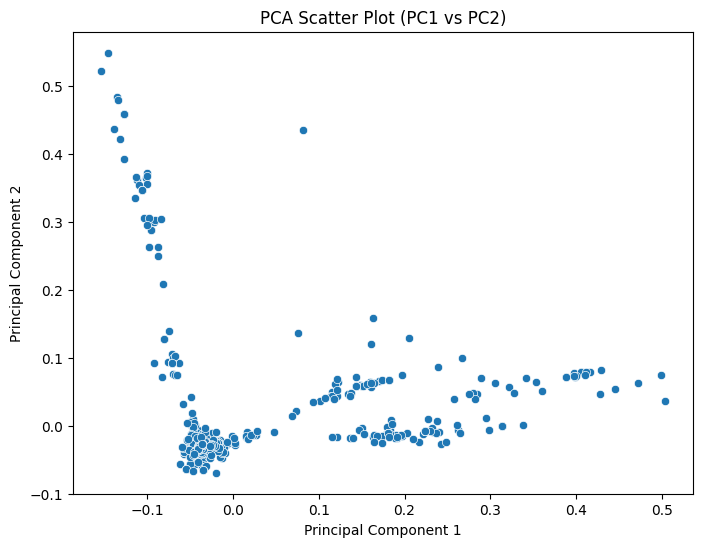

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=df)
plt.title('PCA Scatter Plot (PC1 vs PC2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

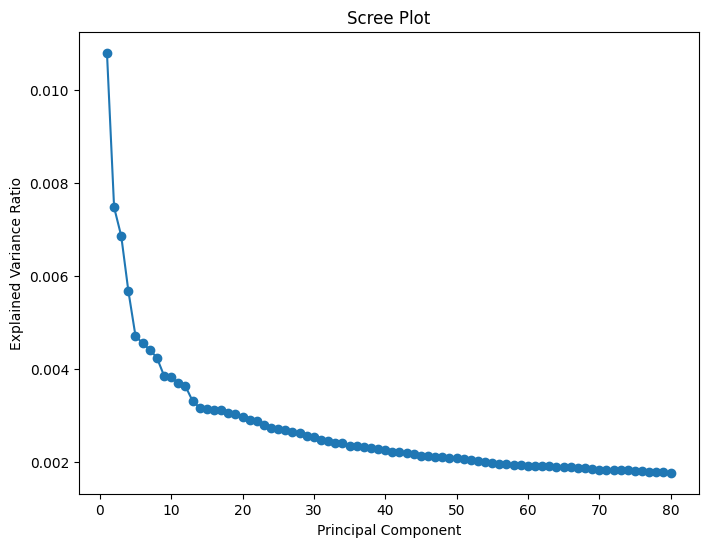

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

### 3.4) Collaborative Filtering

#### 3.4.1) Setup and Data Preparation

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix

print("Using ratings_df with shape:", ratings_df.shape)
ratings_df.head()

Using ratings_df with shape: (8473, 4)


,game_id,user_id,rating,review
0,3322740,76561199245172448,0,"Why this game is not tagged as survival horror if thats clearly major mechanic? \nAnyway, its horrible, enemy ai feels entirely random, it doesnt lose aggro and its frustrating from the get go, Im..."
1,3322740,76561198218674980,0,"gatau ya kenapa game ini terlalu flat banyak moment sebenernya yang bisa dibuat jumpscare tapi kenapa cuma kasih efek lampu pecah?, coba sering sering main game nya emika dan just tom cuk, mungkin..."
2,3322740,76561197961926886,1,"I was able to beat this game after around a minute, this game is severely buggy but it's fun to speedrun so I recommend it B)\r\nhttps://www.youtube.com/watch?v=aXDCKilq8rI"
3,3322780,76561199094964891,1,my son is super excited to play i love it just need more time to play nice job necro love the music and game
4,3322780,76561198102210881,1,"One of my favorite video game genres are Fishing RPGs, which is incredibly niche to come across. Saw the dev advertising this game on Reddit and bought this game day 1 to try out.\n\nRPG Maker, li..."


#### 3.4.2) Creating the User-Item Matrix

In [ ]:
def create_user_item_matrix(ratings_data):
    """
    Create a user-item matrix from the ratings DataFrame.

    Parameters:
    -----------
    ratings_data : pandas DataFrame
        DataFrame containing user_id, game_id, and rating columns

    Returns:
    --------
    user_item_matrix : pandas DataFrame
        A matrix where rows are users, columns are items, and values are ratings
    sparse_user_item : scipy.sparse.csr_matrix
        A sparse matrix representation of the user-item matrix
    """
    # Handle different input types
    if hasattr(ratings_data, 'all_ratings'):  # Check if it's a Surprise Trainset
        # Convert Trainset to DataFrame
        df = pd.DataFrame(ratings_data.all_ratings(), columns=['user_id_inner', 'game_id_inner', 'rating'])
        # Map inner IDs to original IDs
        df['user_id'] = df['user_id_inner'].map(ratings_data.to_raw_uid)
        df['game_id'] = df['game_id_inner'].map(ratings_data.to_raw_iid)
        ratings_data = df[['user_id', 'game_id', 'rating']]
    # Convert to DataFrame if test_df is a list
    if isinstance(ratings_data, list):
        ratings_data = pd.DataFrame(ratings_data, columns=['user_id', 'game_id', 'rating'])

    # Create the user-item matrix
    user_item_matrix = ratings_data.pivot(index='user_id', columns='game_id', values='rating')

    # Fill missing values with 0
    user_item_matrix = user_item_matrix.fillna(0)

    # Convert to sparse matrix for efficiency
    sparse_user_item = csr_matrix(user_item_matrix.values)

    return user_item_matrix, sparse_user_item

# Example: Create a user-item matrix from our ratings data
user_item_matrix, sparse_matrix = create_user_item_matrix(ratings_df)
print("User-Item Matrix Shape:", user_item_matrix.shape)

User-Item Matrix Shape: (8010, 481)


#### 3.4.3) Computing Item Similarity

In [ ]:
def compute_item_similarity(user_item_matrix):
    """
    Compute the cosine similarity between items.

    Parameters:
    -----------
    user_item_matrix : pandas DataFrame
        A matrix where rows are users, columns are items, and values are ratings

    Returns:
    --------
    item_similarity : pandas DataFrame
        A matrix of cosine similarities between items
    """
    # Transpose to get item-user matrix
    item_user = user_item_matrix.T

    # Compute dot product for each pair of items
    dot_product = np.dot(item_user.values, item_user.values.T)

    # Compute magnitude of each item vector
    item_magnitude = np.sqrt(np.sum(item_user.values**2, axis=1))

    # Add small epsilon to avoid division by zero
    item_magnitude = item_magnitude + 1e-8

    # Compute similarity matrix
    similarity = dot_product / np.outer(item_magnitude, item_magnitude)

    # Handle NaN values (when an item has no ratings)
    similarity = np.nan_to_num(similarity)

    # Convert to DataFrame with proper indices
    item_similarity = pd.DataFrame(similarity, index=item_user.index, columns=item_user.index)

    return item_similarity

# Example: Compute item similarity matrix
item_similarity = compute_item_similarity(user_item_matrix)
print("Item Similarity Matrix Shape:", item_similarity.shape)

Item Similarity Matrix Shape: (481, 481)


#### 3.4.4) Prediction Function Using Top-K Similar Items

In [ ]:
def predict_rating(user_id, game_id, user_item_matrix, item_similarity, k=10):
    """
    Predict the rating of a user for an item using the top-k similar items.

    Parameters:
    -----------
    user_id : int or str
        ID of the user
    game_id : int or str
        ID of the game
    user_item_matrix : pandas DataFrame
        A matrix where rows are users, columns are items, and values are ratings
    item_similarity : pandas DataFrame
        A matrix of cosine similarities between items
    k : int, default=10
        Number of most similar items to consider

    Returns:
    --------
    predicted_rating : float
        The predicted rating of the user for the game
    """
    # Check if the game_id is in the similarity matrix
    if game_id not in item_similarity.columns:
        # If not, return the average rating for that user
        user_ratings = user_item_matrix.loc[user_id]
        user_avg = user_ratings[user_ratings > 0].mean()
        return user_avg if not np.isnan(user_avg) else user_item_matrix.values.mean()

    # Get the user's ratings
    user_ratings = user_item_matrix.loc[user_id]

    # Get similarity scores for the target game with all other games
    similarities = item_similarity[game_id]

    # Keep only games that the user has rated
    rated_games = user_ratings[user_ratings > 0].index

    # Get similarities and ratings for these games
    sim_scores = similarities[rated_games].sort_values(ascending=False)
    sim_scores = sim_scores.iloc[:k]  # Take top k

    game_ratings = user_ratings[sim_scores.index]

    # If no similar items were found, return user's average rating
    if len(sim_scores) == 0:
        user_avg = user_ratings[user_ratings > 0].mean()
        return user_avg if not np.isnan(user_avg) else user_item_matrix.values.mean()

    # Compute weighted average
    weighted_sum = np.sum(sim_scores * game_ratings)
    abs_sim_sum = np.sum(np.abs(sim_scores))

    # Handle division by zero
    if abs_sim_sum == 0:
        user_avg = user_ratings[user_ratings > 0].mean()
        return user_avg if not np.isnan(user_avg) else user_item_matrix.values.mean()

    return weighted_sum / abs_sim_sum

# Example: Predict a rating for a specific user-game pair
if len(user_item_matrix.index) > 0 and len(item_similarity.columns) > 0:
    sample_user = user_item_matrix.index[0]
    sample_game = item_similarity.columns[0]
    print(f"Example prediction for user {sample_user}, game {sample_game}:")
    print(f"Predicted rating: {predict_rating(sample_user, sample_game, user_item_matrix, item_similarity):.2f}")

Example prediction for user 76561197960271994, game 39540:
Predicted rating: 1.00


#### 3.4.5) Generating Predictions for Test Set

In [ ]:
def generate_predictions(test_df, user_item_matrix, item_similarity, k=10):
    """
    Generate predictions for the test set.

    Parameters:
    -----------
    test_df : pandas DataFrame
        Test set with user_id, game_id, and rating columns
    user_item_matrix : pandas DataFrame
        A matrix where rows are users, columns are items, and values are ratings
    item_similarity : pandas DataFrame
        A matrix of cosine similarities between items
    k : int, default=10
        Number of most similar items to consider

    Returns:
    --------
    test_df : pandas DataFrame
        Test set with an additional column for predicted ratings
    """
    # Convert to DataFrame if test_df is a list
    if isinstance(test_df, list):
        test_copy = pd.DataFrame(test_df, columns=['user_id', 'game_id', 'rating'])
    else:
        test_copy = test_df.copy()
    predictions = []

    for _, row in test_copy.iterrows():
        user_id = row['user_id']
        game_id = row['game_id']

        # Skip if user or game is not in the training data
        if user_id not in user_item_matrix.index or game_id not in user_item_matrix.columns:
            predictions.append(None)
            continue

        # Predict rating
        pred = predict_rating(user_id, game_id, user_item_matrix, item_similarity, k)
        predictions.append(pred)

    # Add predictions to test_df
    test_copy['predicted_rating'] = predictions

    # Drop rows with None predictions
    test_copy = test_copy.dropna(subset=['predicted_rating'])

    return test_copy

#### 3.4.6) Evaluating the Predictions

In [ ]:
def evaluate_predictions(test_df):
    """
    Evaluate the predictions using various metrics.

    Parameters:
    -----------
    test_df : pandas DataFrame
        Test set with actual and predicted ratings

    Returns:
    --------
    metrics : dict
        Dictionary containing evaluation metrics
    """
    y_true = test_df['rating']
    y_pred = test_df['predicted_rating']

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    }

    return metrics

#### 3.4.7) Visualizing True vs. Predicted Ratings


In [ ]:
def plot_comparison(test_df):
    """
    Create a violin plot comparing true vs predicted ratings.

    Parameters:
    -----------
    test_df : pandas DataFrame
        Test set with actual and predicted ratings
    """
    # Create a long-format DataFrame for seaborn
    comparison_df = pd.DataFrame({
        'True Ratings': test_df['rating'],
        'Predicted Ratings': test_df['predicted_rating']
    })

    comparison_long = pd.melt(comparison_df, var_name='Type', value_name='Rating')

    # Create violin plot
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Type', y='Rating', data=comparison_long, inner='quartile')
    plt.title('Comparison of True vs Predicted Ratings')
    plt.ylabel('Rating')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    return plt

#### 3.4.8) Complete Item-Based Collaborative Filtering Pipeline

In [ ]:
def item_based_collaborative_filtering(train_df, test_df, k=10):
    """
    Complete item-based collaborative filtering pipeline.

    Parameters:
    -----------
    ratings_data : pandas DataFrame
        DataFrame containing user_id, game_id, and rating columns
    k : int, default=10
        Number of most similar items to consider

    Returns:
    --------
    results : dict
        Dictionary containing evaluation metrics and other outputs
    """
    # Convert to DataFrame if test_df is a list
    if isinstance(test_df, list):
        test_df = pd.DataFrame(test_df, columns=['user_id', 'game_id', 'rating'])

    # Create user-item matrix from training data
    user_item_matrix, _ = create_user_item_matrix(train_df)

    # Compute item similarity
    item_similarity = compute_item_similarity(user_item_matrix)

    # Generate predictions
    test_with_predictions = generate_predictions(test_df, user_item_matrix, item_similarity, k)

    # Evaluate predictions
    metrics = evaluate_predictions(test_with_predictions)

    results = {
        'user_item_matrix': user_item_matrix,
        'item_similarity': item_similarity,
        'test_with_predictions': test_with_predictions,
        'metrics': metrics,
    }

    return results

#### 3.4.9) Making Recommendations for Users

In [ ]:
def recommend_games_for_user(user_id, user_item_matrix, item_similarity, n_recommendations=5):
    """
    Recommend new games for a specific user.

    Parameters:
    -----------
    user_id : int or str
        ID of the user
    user_item_matrix : pandas DataFrame
        User-item matrix
    item_similarity : pandas DataFrame
        Item similarity matrix
    n_recommendations : int, default=5
        Number of recommendations to generate

    Returns:
    --------
    recommendations : pandas DataFrame
        DataFrame with recommended games and predicted ratings
    """
    # Check if user exists in the matrix
    if user_id not in user_item_matrix.index:
        print(f"User {user_id} not found in the dataset")
        return None

    # Get the games already rated by the user
    user_ratings = user_item_matrix.loc[user_id]
    rated_games = user_ratings[user_ratings > 0].index.tolist()

    # Find games not rated by the user
    unrated_games = [game for game in user_item_matrix.columns if game not in rated_games]

    # Predict ratings for unrated games
    predictions = []
    for game_id in unrated_games:
        pred_rating = predict_rating(user_id, game_id, user_item_matrix, item_similarity)
        if pred_rating is not None:  # Only include predictions that were successful
            game_name = items_df.loc[game_id, 'name']
            predictions.append((game_id, game_name, pred_rating))

    # Sort by predicted rating and get top n recommendations
    recommendations = sorted(predictions, key=lambda x: x[1], reverse=True)[:n_recommendations]

    # Convert to DataFrame
    rec_df = pd.DataFrame(recommendations, columns=['game_id', 'game_name', 'predicted_rating'])

    return rec_df

## <font color="green">4) Split train-test

In [ ]:
ratings_df = pd.read_csv(f'{dataset_path}/steam_reviews.csv')
ratings_df.head()

,game_id,user_id,rating,review
0,3322740,76561199245172448,0,"Why this game is not tagged as survival horror if thats clearly major mechanic? \nAnyway, its horrible, enemy ai feels entirely random, it doesnt lose aggro and its frustrating from the get go, Im..."
1,3322740,76561198218674980,0,"gatau ya kenapa game ini terlalu flat banyak moment sebenernya yang bisa dibuat jumpscare tapi kenapa cuma kasih efek lampu pecah?, coba sering sering main game nya emika dan just tom cuk, mungkin..."
2,3322740,76561197961926886,1,"I was able to beat this game after around a minute, this game is severely buggy but it's fun to speedrun so I recommend it B)\r\nhttps://www.youtube.com/watch?v=aXDCKilq8rI"
3,3322780,76561199094964891,1,my son is super excited to play i love it just need more time to play nice job necro love the music and game
4,3322780,76561198102210881,1,"One of my favorite video game genres are Fishing RPGs, which is incredibly niche to come across. Saw the dev advertising this game on Reddit and bought this game day 1 to try out.\n\nRPG Maker, li..."


In [ ]:
from surprise.model_selection import train_test_split as surprise_train_test_split

In [ ]:
# Define rating scale
reader = Reader(rating_scale=(ratings_df['rating'].min(), ratings_df['rating'].max()))

# Load data into Surprise format
data = Dataset.load_from_df(ratings_df[['user_id', 'game_id', 'rating']], reader)

# Perform train-test split
#train_df, test_df = prepare_train_test_data(ratings_df)
#trainset, testset = prepare_train_test_data(data, test_size=0.2, random_state=my_seed) # no gurantiee that all data from user is devided some in test and some in train
#trainset, testset = train_test_split(data, test_size=0.2, random_state=my_seed) # no gurantiee that all data from user is devided some in test and some in train
trainset, testset = surprise_train_test_split(data, test_size=0.2, random_state=my_seed) # no gurantiee that all data from user is devided some in test and some in train

## <font color="green">5) Train and Test Recommender Systems

**\# RANDOM PREDICTIONS**

In [ ]:
random_RS.fit(trainset);

predictions_random = random_RS.test(testset)
accuracy.rmse(predictions_random)
accuracy.mae(predictions_random)

RMSE: 0.5578
MAE:  0.4313


0.4312768430253038

**\# POPULAR RECOMMENDER PREDICTIONS**

In [ ]:
popular_RS.fit(trainset);

predictions_popular = popular_RS.test(testset)
accuracy.rmse(predictions_popular)
accuracy.mae(predictions_popular)

RMSE: 0.4203
MAE:  0.3284


0.3284067548077488

**\# CONTENT BASED PREDICTIONS**

In [ ]:
predictions = []
for user_id, game_id, true_rating in testset:
  predicted_rating = content_based_RS.get_recommendations(user_id, top_n=1) # top_n=1 returns list of one id
  if predicted_rating and predicted_rating[0] == game_id: # if prediction is in top 1
    predictions.append((user_id, game_id, true_rating, 1, {}))
  else:
    predictions.append((user_id, game_id, true_rating, 0, {}))

In [ ]:
content_based_RS = ContentBasedRecommender(ratings_df, items_df)
# 5. Calculate RMSE and MAE
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 0.8136
MAE:  0.6619


**\# COLLABORATIVE FILTERING PREDICTIONS**

In [ ]:
# COLLABORATIVE FILTERING PREDICTIONS

# ITEM-BASED COLLABORATIVE FILTERING PREDICTIONS

# Prepare data by dropping duplicates to avoid pivot table issues
ratings_df_clean = ratings_df.drop_duplicates(subset=['user_id', 'game_id'], keep='last')

# Convert the Surprise trainset to a Pandas DataFrame
train_df = pd.DataFrame(trainset.all_ratings(), columns=['user_id_inner', 'game_id_inner', 'rating'])
# Map inner IDs to original user_id and game_id
train_df['user_id'] = train_df['user_id_inner'].map(trainset.to_raw_uid)
train_df['game_id'] = train_df['game_id_inner'].map(trainset.to_raw_iid)
train_df = train_df[['user_id', 'game_id', 'rating']]

# Create user-item matrix from training data
user_item_matrix, _ = create_user_item_matrix(train_df)

# Compute item similarity matrix
item_similarity = compute_item_similarity(user_item_matrix)

# Generate predictions on test set
test_with_predictions = generate_predictions(testset, user_item_matrix, item_similarity, k=10)

# Calculate RMSE and MAE
predictions_collab = test_with_predictions['predicted_rating'].values
actual_ratings = test_with_predictions['rating'].values

# Import required metrics from sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate metrics directly with sklearn instead of using accuracy object
rmse = np.sqrt(mean_squared_error(actual_ratings, predictions_collab))
mae = mean_absolute_error(actual_ratings, predictions_collab)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 0.408248290463863
MAE: 0.16666666666666666


## <font color="green">6) Metrics and Result

### 6.1) Analize Results

SEE PREDICTIONS

**\# RANDOM PREDICTIONS**

In [ ]:
columns=['user', 'item', 'true_rating', 'predicted_rating', 'details']
predictions_random_df = pd.DataFrame(predictions_random, columns=columns)
predictions_random_df.head()

,user,item,true_rating,predicted_rating,details
0,76561198060466148,987840,1.0,1.000000,{'was_impossible': False}
1,76561198091961482,45770,1.0,0.584431,{'was_impossible': False}
2,76561198139292046,2316410,0.0,0.770226,{'was_impossible': False}
3,76561198210914592,2185880,1.0,0.954470,{'was_impossible': False}
4,76561198796725761,1582290,1.0,0.962970,{'was_impossible': False}


In [ ]:
def get_random_recommendations(user_id, top_n=10, printdf=True):
  """
  Generate random recommendations for a user and display them in a DataFrame.

  Args:
      user_id (int): The ID of the user for whom to generate recommendations.
      top_n (int, optional): The number of recommendations to generate. Defaults to 10.

  Returns:
      pd.DataFrame: A DataFrame containing the recommendations with ID, name, and confidence score.
  """

  # Get all game IDs from your items_df
  all_game_ids = items_df.index.tolist()

  # Generate random recommendations
  recommendations = []
  for game_id in random.sample(all_game_ids, top_n):
      predicted_rating = random_RS.predict(user_id, game_id).est  # Get estimated rating
      recommendations.append([game_id, items_df.loc[game_id, 'name'], predicted_rating])

  # Create a Pandas DataFrame
  recommendations_df = pd.DataFrame(recommendations, columns=['ID', 'Name', 'Confidence Score'])

  if printdf: display(recommendations_df)  # Display the DataFrame using IPython.display

  return recommendations_df

In [ ]:
# Example usage
user_id_to_recommend = 76561197961926886  # Replace with a specific user ID
print(f"Random recommendations for user {user_id_to_recommend}:")
recommendations = get_random_recommendations(user_id_to_recommend)

Random recommendations for user 76561197961926886:


,ID,Name,Confidence Score
0,45760,Ultra Street Fighter IV,0.776740
1,2187190,Poly Shoot,0.342053
2,2316820,Rudra : A Tale of Time,0.761095
3,3322780,Deep Horrors of Fishing,1.000000
4,2317170,I REMEMBER,0.845475
5,1582380,Midautumn,1.000000
6,1584080,Stitched : Mother 's Nightmare,0.282668
7,2567360,DummyDoodle,0.164397
8,3321790,Careening,0.214219
9,989190,Slay All Goblins,0.942440


**\# POPULAR PREDICTIONS**

In [ ]:
columns=['user', 'item', 'true_rating', 'predicted_rating', 'details']
predictions_popular_df = pd.DataFrame(predictions_popular, columns=columns)
predictions_popular_df.head()

,user,item,true_rating,predicted_rating,details
0,76561198060466148,987840,1.0,0.750000,{'was_impossible': False}
1,76561198091961482,45770,1.0,0.756098,{'was_impossible': False}
2,76561198139292046,2316410,0.0,0.400000,{'was_impossible': False}
3,76561198210914592,2185880,1.0,0.789474,{'was_impossible': False}
4,76561198796725761,1582290,1.0,0.952381,{'was_impossible': False}


In [ ]:
def get_popular_recommendations(user_id, top_n=10, printdf=True):
  """
  Generate popular recommendations for a user and display them in a DataFrame.

  Args:
      user_id (int): The ID of the user for whom to generate recommendations.
      top_n (int, optional): The number of recommendations to generate. Defaults to 10.

  Returns:
      pd.DataFrame: A DataFrame containing the recommendations with ID, name, and confidence score.
  """

  # Get all game IDs from your items_df
  all_game_ids = items_df.index.tolist()

  # Generate popular recommendations
  recommendations = []
  for game_id in all_game_ids:
      predicted_rating = popular_RS.predict(user_id, game_id).est  # Get estimated rating
      recommendations.append([game_id, items_df.loc[game_id, 'name'], predicted_rating])

  # Create a Pandas DataFrame
  recommendations_df = pd.DataFrame(recommendations, columns=['ID', 'Name', 'Confidence Score'])

  # Sort by Confidence Score and get top_n
  recommendations_df = recommendations_df.sort_values(by=['Confidence Score'], ascending=False).head(top_n)

  if printdf: display(recommendations_df)  # Display the DataFrame using IPython.display

  return recommendations_df

In [ ]:
# Example usage
user_id_to_recommend = 76561197961926886  # Replace with a specific user ID
print(f"Popular recommendations for user {user_id_to_recommend}:")
recommendations = get_popular_recommendations(user_id_to_recommend)

Popular recommendations for user 76561197961926886:


,ID,Name,Confidence Score
154,2271300,Safehouse,1.0
701,988640,Christmas Wonderland,1.0
171,2270640,Grim Tales : The Time Traveler Collector 's Edition,1.0
698,989430,随风而逝/Story About Times,1.0
586,2567880,Gloves On !,1.0
695,989380,Beard of Stone,1.0
161,2270500,Inn Hand,1.0
324,2556670,Spellslinger,1.0
249,2269420,Phanotia I : Escavive,1.0
136,2315990,孵化之地 wild eclosion,1.0


**\# CONTENT BASED PREDICTIONS**

In [ ]:
columns = ['user', 'item', 'true_rating', 'predicted_rating', 'details']
predictions_content_based_df = pd.DataFrame(predictions, columns=columns) # Use 'predictions' instead of 'predictions_content_based'
predictions_content_based_df.head()

,user,item,true_rating,predicted_rating,details
0,76561198060466148,987840,1.0,0,{}
1,76561198091961482,45770,1.0,0,{}
2,76561198139292046,2316410,0.0,1,{}
3,76561198210914592,2185880,1.0,1,{}
4,76561198796725761,1582290,1.0,0,{}


---

In [ ]:
import numpy as np

def get_content_based_recommendations(user_id, top_n=10, printdf=True):
    """
    Generate content-based recommendations for a user and display them in a DataFrame.

    Args:
        user_id (int): The ID of the user for whom to generate recommendations.
        top_n (int, optional): The number of recommendations to generate. Defaults to 10.

    Returns:
        pd.DataFrame: A DataFrame containing the recommendations with ID, name, and probability score.
    """
    import pandas as pd
    from sklearn.metrics.pairwise import cosine_similarity

    # Get recommendations using your ContentBasedRecommender
    recommended_game_ids = content_based_RS.get_recommendations(user_id, top_n=top_n)

    # Calculate relevance scores for all recommended games
    relevance_scores = []
    for game_id in recommended_game_ids:
        # Get the user's rated games
        user_rated_games = ratings_df[ratings_df['user_id'] == user_id]['game_id'].tolist()

        # Get TF-IDF vectors for user's rated games and the candidate game
        user_rated_vectors = tfidf_matrix_names[items_df.index.isin(user_rated_games)]
        candidate_game_vector = tfidf_matrix_names[items_df.index == game_id]

        # Calculate average cosine similarity between user's rated games and candidate game
        if user_rated_vectors.shape[0] > 0:
            similarity_scores = cosine_similarity(user_rated_vectors, candidate_game_vector)
            relevance_score = similarity_scores.mean()  # Average similarity as relevance
        else:
            relevance_score = 0.0  # Default to 0 if user has no rated games

        relevance_scores.append(relevance_score)

    # Apply softmax to convert relevance scores to probabilities
    probabilities = np.exp(relevance_scores) / np.sum(np.exp(relevance_scores))

    # Create a list to store recommendations data
    recommendations = []
    for i, game_id in enumerate(recommended_game_ids):
        recommendations.append([game_id, items_df.loc[game_id, 'name'], probabilities[i]])

    # Create a Pandas DataFrame
    recommendations_df = pd.DataFrame(recommendations, columns=['ID', 'Name', 'Probability'])

    if printdf: display(recommendations_df)  # Display the DataFrame using IPython.display

    return recommendations_df

In [ ]:
# Example usage
user_id_to_recommend = 76561197961926887  # Replace with a specific user ID
print(f"Content-based recommendations for user {user_id_to_recommend}:")
recommendations = get_content_based_recommendations(user_id_to_recommend)

Content-based recommendations for user 76561197961926887:


,ID,Name,Probability
0,2556660,Car Manufacture : Prologue Playtest,0.1
1,2556640,Get Out Joey ! Playtest,0.1
2,2556630,复仇者小队,0.1
3,2556620,True Boxing VR,0.1
4,2556540,Anachronic,0.1
5,2556490,Drift Vector,0.1
6,2556480,End of Space Project,0.1
7,2556470,Fantastic Haven,0.1
8,2556450,哈希绿洲（Hash Oasis）,0.1
9,2557080,Kitten Tales,0.1


**\# COLLABORATIVE FILTERING PREDICTIONS**

In [ ]:
# Run the collaborative filtering pipeline
results = item_based_collaborative_filtering(trainset, testset, k=10)

# Example: Get recommendations for a random user from our dataset
if len(user_item_matrix.index) > 0:
    sample_user = 76561198064204125#np.random.choice(user_item_matrix.index)
    user_recommendations = recommend_games_for_user(
        sample_user,
        results['user_item_matrix'],
        results['item_similarity'],
        n_recommendations=5
    )

    print(f"\nTop 5 game recommendations for user {sample_user}:")
    print(user_recommendations)


Top 5 game recommendations for user 76561198064204125:
   game_id               game_name  predicted_rating
0   989430  随风而逝/Story About Times               1.0
1  2568410                   第九竞技场               1.0
2   989450                    时之回廊               1.0
3  2316480                   擒贼先擒王               1.0
4  1584140                  打工人：美香               1.0


### 6.2) Accuracy </font>

Measuring the accuracy of our RS lies in using the very known regression and classification metrix that we know form previous knowledge.

In the end what we are measuring here is the precision of our predicted values agains true values with metrix like MAE, R^2, etc... for regression and confusion matrices, recall, etc... for classification.

In the case of RS we measure the coosness/accuracy of our prediction about how much the user would like and item.

1. Collaborative Filtering RS
2. Popular RS
2. Content-Based RS
3. Random RS

1. Collaborative filtering RS is supposed to classify higher under this metrix. Infact in this RS we are feeding the user with something other similar users to him liked in the past! As a natural conclusion, the items shown will be liked be the user that will iteract with them most of the times.

2. After that I put the Popular RS. As saw in class, this RS is very difficult to beat, as a proof of that the Long Tail phenomeno. By reccomending trends to the user, feeding him with items that most of users liked, we have an average of iteraction very high. Therfore high precision will be shown by the metrics.

3. Later I classify the content based RS, that is almost on the same level of Popular. In reality I belive that second and third place can vary based on diffrent data **(as a matter of fact, data is the treasure of this systems, in fact if no data, even the Collaborative filtering might end up last!!!)**.

4. Last but not least, my favorite, the random reccomender. For sure, under this metrix it will perofm very badly. Recomending an item, randomly to a user, we have very low chances to chose the exact one that allign with his taste. It is like shooting a dard blind-folded in the immense variety of our items catalogue.

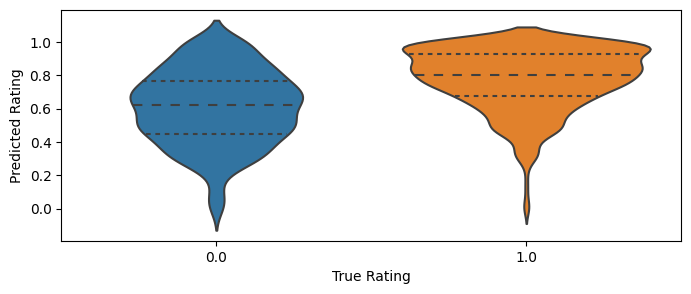

In [ ]:
plt.subplots(figsize=(8, 3))
sns.violinplot(data=predictions_popular_df,x='true_rating',y='predicted_rating', inner='quartile')
plt.xlabel('True Rating')
plt.ylabel('Predicted Rating')
plt.show()

This plot shows that popular R is good at defining when an item was 0. It predict 0 and it was actulay 0.

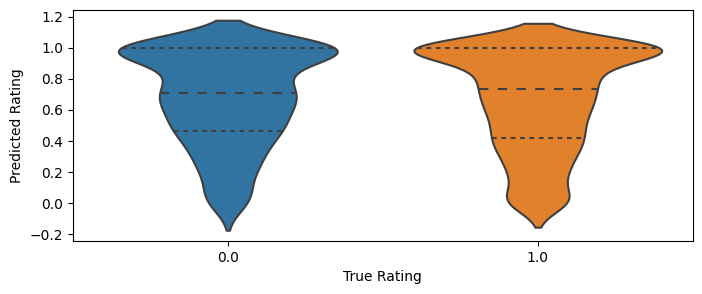

In [ ]:
plt.subplots(figsize=(8, 3))
sns.violinplot(data=predictions_random_df,x='true_rating',y='predicted_rating', inner='quartile')
plt.xlabel('True Rating')
plt.ylabel('Predicted Rating')
plt.show()

As expected the random reccomender predict 0's and 1's at random, so the distributions of guessing are more or less the same

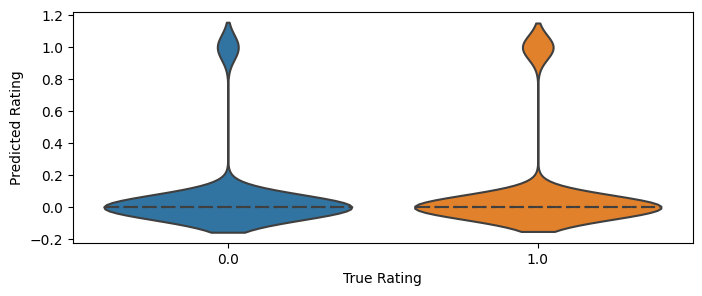

In [ ]:
plt.subplots(figsize=(8, 3))
sns.violinplot(data=predictions_content_based_df,x='true_rating',y='predicted_rating', inner='quartile')
plt.xlabel('True Rating')
plt.ylabel('Predicted Rating')
plt.show()

---

REGRESSION METRICS

In [ ]:
def get_explicit_metrics(true_ratings, predictions, verbose=False):
    mae = mean_absolute_error(true_ratings, predictions)
    mse = mean_squared_error(true_ratings, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_ratings, predictions)

    if verbose:
        print(f'MAE: {mae}\nMSE: {mse}\nRMSE: {rmse}\nR2: {r2}\n')

    return mae, mse, rmse, r2

In [ ]:
mae, mse, rmse, r2 = get_explicit_metrics(
    predictions_popular_df['true_rating'],
    predictions_popular_df['predicted_rating'],
    verbose=True
)

MAE: 0.3284067548077488
MSE: 0.17664689289194332
RMSE: 0.4202938173372805
R2: 0.12422616143075871



In [ ]:
mae, mse, rmse, r2 = get_explicit_metrics(
    predictions_random_df['true_rating'],
    predictions_random_df['predicted_rating'],
    verbose=True
)

MAE: 0.4312768430253038
MSE: 0.3111319399982075
RMSE: 0.5577920221715326
R2: -0.5425191404889558



In [ ]:
mae, mse, rmse, r2 = get_explicit_metrics(
    predictions_content_based_df['true_rating'],
    predictions_content_based_df['predicted_rating'],
    verbose=True
)

MAE: 0.6619469026548672
MSE: 0.6619469026548672
RMSE: 0.8136011938627347
R2: -2.281777394305435



---

CONFUSION MATRIX

Confusion Matrix - Popular RS



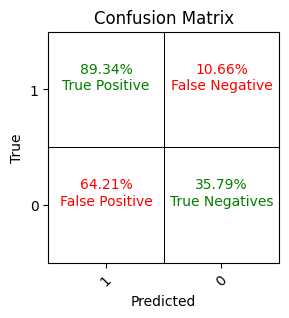

In [ ]:
# create new column 'predicted_rating_rounded' to approximate prediction to nearens integer 1 or 0
predictions_popular_df['predicted_rating_rounded'] = predictions_popular_df['predicted_rating'].round()
fig = plt.figure(figsize=(3,3))
print("Confusion Matrix - Popular RS\n")
recmetrics.make_confusion_matrix(y=predictions_popular_df['true_rating'],
                                 yhat=predictions_popular_df['predicted_rating_rounded'])

Confusion Matrix - Random RS



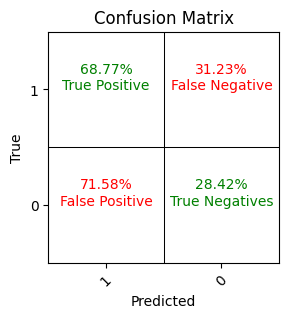

In [ ]:
# create new column 'predicted_rating_rounded' to approximate prediction to nearens integer 1 or 0
predictions_random_df['predicted_rating_rounded'] = predictions_random_df['predicted_rating'].round()
fig = plt.figure(figsize=(3,3))
print("Confusion Matrix - Random RS\n")
recmetrics.make_confusion_matrix(y=predictions_random_df['true_rating'],
                                 yhat=predictions_random_df['predicted_rating_rounded'])

Confusion Matrix - Content Based RS



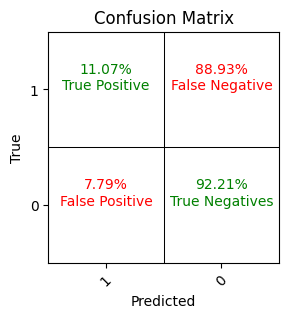

In [ ]:
predictions_content_based_df['predicted_rating_rounded'] = predictions_content_based_df['predicted_rating'].round()
fig = plt.figure(figsize=(3,3))
print("Confusion Matrix - Content Based RS\n")
recmetrics.make_confusion_matrix(y=predictions_content_based_df['true_rating'],
                                 yhat=predictions_content_based_df['predicted_rating_rounded'])

It has learned much better how to find True negative due to umbalance in the dataset

### 6.3) Coverage </font>


By coverage we think about the persentage of catalogue we show. It is crucial to not evaluate only accuracy in this field of RS. In fact:
  - 90% accuracy but show 10% catalogue
  - 89% accuracy but show 70% catalogue => this one is **much** better

1. Random RS
1. Collaborative Filtering RS
2. Content-Based RS
2. Popular RS


1. In this metric, Random RS score higest!! As definition, this RS is used in A/B testing to gather data of all items in the ctaloge, even the ones that would never be shoun by other types of RS (such popular RS).

2. Collaborative Filtering score second. Based on my knowlege of this RS, I immagine it to give to each user diffrent items, based on what similar users liked. This allows the RS to show more items than other RS, with higher varaiety (If we think about cold start this model might go at third launching content based at second. Collaborative Filtering can show a variety of items but is limited by user interactions. Items that haven’t been rated before might never be recommended.)

3. Content based is third because it shows the user only similar items to the ones he liked, so in the end will just cover small portion of the all catalogue. in other words, Content-Based RS covers only items that have features similar to what the user has interacted with, so it limits exposure to new or unique items.

4. Lastly the Popular RS, becasu will concentrate on the few items with high interaction discarding the most of the cataloque with low/null interactions (long tail phenomeno reflection!)

In [ ]:
# caount catalog (number of items)
catalog_size_rating = ratings_df['game_id'].unique()
len(catalog_size_rating)

481

In [ ]:
catalog_size_items = len(items_df)
catalog_size_items

943

In [ ]:
covergae_random = recmetrics.prediction_coverage(predictions_random_df, catalog_size_rating)
covergae_random

3.33

In [ ]:
coverage_popular = recmetrics.prediction_coverage(predictions_popular_df, catalog_size_rating)
coverage_popular

3.33

In [ ]:
coverage_content_based = recmetrics.prediction_coverage(predictions_content_based_df, catalog_size_rating)
coverage_content_based

3.33

In [ ]:
#coverage_collab = recmetrics.prediction_coverage(predictions_collab, catalog_size_rating)
#coverage_collab

### 6.4) Personalization</font>

Are users reciving differenct or similar items?

1. Collaborative Filtering RS
2. Content-Based RS
2. Popular RS
2. Random RS



1. In collaborative, each user will recive a very custom home page, tuned to his likes, passions, etc...

2. In this model (Content based) each user have a very personalized experience based on similar items to the ones he liked/iteracted before.

3. In popular we reccomend the items that are trend of the moment. Thus each user will recive the same "personalization"

4. For Random RS, it is by definition lacking of personalization. It will give items at random, not based on any user taste trends.

In [ ]:
def extract_ids(recommendations_df):
  if recommendations_df.empty:
    return []

  if 'ID' not in recommendations_df.columns:
    return []

  return recommendations_df['ID'].tolist()

In [ ]:
# get reccomandations for user 76561198153704486 with random RS
recommendations = get_random_recommendations(76561198153704486)

,ID,Name,Confidence Score
0,2555320,Повестка,1.000000
1,990280,Olimdal,0.501200
2,990900,Neon Noodles,1.000000
3,2186130,Zarlor Mercenary,0.000000
4,2567060,Ship Regulus,0.581159
5,2186640,Order Automatica Playtest,0.382979
6,2271270,DEVIL 'S LIMINAL,0.750533
7,2317180,Cube Crusaders,0.349378
8,2270200,Simnetzero,0.000000
9,987950,eBall,1.000000


In [ ]:
extract_ids(recommendations)

[2555370,
 989350,
 2555690,
 3323020,
 989550,
 2269290,
 2270350,
 2567730,
 2567410,
 2569820]

In [ ]:
predictions = []

for i in range(4):
    user = np.random.choice(user_item_matrix.index)
    predictions.append(extract_ids(get_random_recommendations(i, printdf=False)))

In [ ]:
recmetrics.personalization(predictions)

0.9666666666666667

In [ ]:
# get popular reccomandations for user 76561198153704486
recommendations = get_popular_recommendations(76561198153704486)

,ID,Name,Confidence Score
154,2271300,Safehouse,1.0
701,988640,Christmas Wonderland,1.0
171,2270640,Grim Tales : The Time Traveler Collector 's Edition,1.0
698,989430,随风而逝/Story About Times,1.0
586,2567880,Gloves On !,1.0
695,989380,Beard of Stone,1.0
161,2270500,Inn Hand,1.0
324,2556670,Spellslinger,1.0
249,2269420,Phanotia I : Escavive,1.0
136,2315990,孵化之地 wild eclosion,1.0


In [ ]:
extract_ids(recommendations)

[2271300,
 988640,
 2270640,
 989430,
 2567880,
 989380,
 2270500,
 2556670,
 2269420,
 2315990]

In [ ]:
predictions = []

for i in range(4):
    user = np.random.choice(user_item_matrix.index)
    predictions.append(extract_ids(get_popular_recommendations(i, printdf=False)))

In [ ]:
recmetrics.personalization(predictions)

1.1102230246251565e-16

In [ ]:
content_based_RS = ContentBasedRecommender(ratings_df, items_df)

# 2. Get recommendations for a specific user user_id = 76561198153704486
user_id = 76561198153704486
#recommendations = content_based_RS.get_recommendations(user_id, top_n=10)

# 3. Print the recommendations
recommendations = get_content_based_recommendations(user_id_to_recommend)


#print(f"Recommendations for user {user_id}:")
#for game_id in recommendations:
#    game_name = items_df.loc[game_id, 'name']
#    print(f"- {game_name} (game_id: {game_id})")

,ID,Name,Probability
0,2556660,Car Manufacture : Prologue Playtest,0.1
1,2556640,Get Out Joey ! Playtest,0.1
2,2556630,复仇者小队,0.1
3,2556620,True Boxing VR,0.1
4,2556540,Anachronic,0.1
5,2556490,Drift Vector,0.1
6,2556480,End of Space Project,0.1
7,2556470,Fantastic Haven,0.1
8,2556450,哈希绿洲（Hash Oasis）,0.1
9,2557080,Kitten Tales,0.1


In [ ]:
extract_ids(recommendations)

[2556660,
 2556640,
 2556630,
 2556620,
 2556540,
 2556490,
 2556480,
 2556470,
 2556450,
 2557080]

In [ ]:
predictions = []

for i in range(4):
    user = np.random.choice(user_item_matrix.index)
    predictions.append(extract_ids(get_content_based_recommendations(i, printdf=False)))

In [ ]:
recmetrics.personalization(predictions)

1.1102230246251565e-16

In [ ]:
# get collab filtering reccomandations for user 76561198153704486
# Run the collaborative filtering pipeline
results = item_based_collaborative_filtering(trainset, testset, k=10)

# Example: Get recommendations for a random user from our dataset
if len(user_item_matrix.index) > 0:
    sample_user = 76561198064204125 #np.random.choice(user_item_matrix.index)
    user_recommendations = recommend_games_for_user(
        sample_user,
        results['user_item_matrix'],
        results['item_similarity'],
        n_recommendations=5
    )

    print(f"\nTop 5 game recommendations for user {sample_user}:")
    print(user_recommendations)


Top 5 game recommendations for user 76561198064204125:
   game_id               game_name  predicted_rating
0   989430  随风而逝/Story About Times               1.0
1  2568410                   第九竞技场               1.0
2   989450                    时之回廊               1.0
3  2316480                   擒贼先擒王               1.0
4  1584140                  打工人：美香               1.0


In [ ]:
def extract_game_ids_from_collab_filtering(recommendations):
  """
  Extracts game IDs from collaborative filtering recommendations.

  Args:
    recommendations: The result of the collaborative filtering
                     recommendation function (e.g., user_recommendations).

  Returns:
    A list of game IDs. Returns an empty list if input is invalid or empty.
  """
  if not isinstance(recommendations, (pd.Series, list, np.ndarray)):
    return []

  if isinstance(recommendations, pd.Series):
    return recommendations.index.tolist()
  elif isinstance(recommendations, (list, np.ndarray)):
      return recommendations
  else:
      return []


# Example usage (assuming 'user_recommendations' is defined as in the provided code):
# Run the collaborative filtering pipeline (assuming this part of your code is executed)
# results = item_based_collaborative_filtering(trainset, testset, k=10)

# Example: Get recommendations for a random user from our dataset
if len(user_item_matrix.index) > 0:
    sample_user = np.random.choice(user_item_matrix.index)
    user_recommendations = recommend_games_for_user(
        sample_user,
        results['user_item_matrix'],
        results['item_similarity'],
        n_recommendations=5
    )

    game_ids = extract_game_ids_from_collab_filtering(user_recommendations)
    print(f"\nGame IDs for user {sample_user}: {game_ids}")



Game IDs for user 76561198042628923: []


### 6.5) Diversity</font>

1. Random RS
1. Collaborative Filtering RS
2. Content-Based RS
2. Popular RS


1. All users home page is different, so Random RS show at each user different items.

2. based on the similar users we can suggest items that are not connected to the one already consumed by the users. Thsi allow Collaborative filtering to offer more items catalogue to the user homepage. (this might be at same level of content based. Collaborative Filtering offers more diversity than Content-Based but can still suffer from popularity bias, limiting its range.)

3. There is not a lot of diversity in the items, as we said before this model suffer of the filter bubble. This mean that we will sugest only items similar to the one already consuming without any serendipity!

4. All users have the same items suggestions

### 6.6) Ranking (NDCG score)

Capability of showing best items for the user first

In [ ]:
def calculate_ndcg(model, trainset, testset, k=10):
    """Calculates the NDCG score for a given model."""

    # Get predictions for the test set
    predictions = model.test(testset)

    # Create a DataFrame with user_id, game_id, and predicted rating
    predictions_df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])

    # Group predictions by user_id
    user_predictions = predictions_df.groupby('uid')

    # Calculate NDCG for each user and average them
    ndcg_scores = []
    for user_id, group in user_predictions:
        try:  # Wrap in a try-except block to handle missing users
            # Get true ratings for the user
            true_ratings = trainset.ur[trainset.to_inner_uid(user_id)]  # Get user's ratings from trainset
            true_ratings_df = pd.DataFrame(true_ratings, columns=['iid_inner', 'rating'])
            true_ratings_df['iid'] = true_ratings_df['iid_inner'].map(trainset.to_raw_iid)  # Map inner item IDs to raw item IDs

            # Get predicted ratings for the user
            predicted_ratings = group[['iid', 'est']].sort_values('est', ascending=False)  # Sort by estimated rating

            # Create relevance scores (1 for relevant, 0 for irrelevant)
            relevance = true_ratings_df.set_index('iid').reindex(predicted_ratings['iid']).fillna(0)['rating']
            relevance = relevance.values  # Convert to NumPy array

            # Calculate NDCG for the user (if there are relevant items)
            if relevance.sum() > 0:
                ndcg_scores.append(ndcg_score([relevance], [predicted_ratings['est'].values], k=k))

        except ValueError:  # User not in trainset
            # Handle the case where the user is not in the trainset
            # For example, you could skip this user or assign a default NDCG score
            pass  # Or ndcg_scores.append(0)


    # Return the average NDCG score
    return np.mean(ndcg_scores) if ndcg_scores else 0


In [ ]:
ndcg_random = calculate_ndcg(random_RS, trainset, testset)
ndcg_popular = calculate_ndcg(popular_RS, trainset, testset)
#ndcg_content_based = calculate_ndcg(content_based_RS, trainset, testset)  # Assuming content_based_RS is a Surprise algorithm

In [ ]:
print(f"NDCG for Random RS: {ndcg_random:.4f}")
print(f"NDCG for Popular RS: {ndcg_popular:.4f}")
#print(f"NDCG for Content-Based RS: {ndcg_content_based:.4f}")

NDCG for Random RS: 0.0000
NDCG for Popular RS: 0.0000
